This notebook was authored by **Marcos Tidball**, [@zysymu](https://github.com/zysymu) on GitHub!

# Large Language Models and Topic Modelling for Textual Information Extraction and Analysis

In this notebook I explore how we can process narratives using tabular data and a medical-term translation dictionary to make them more understandable. I then use a text2text generation pretrained Large Language Model (LLM) as an information extractor to obtain information present only on the narratives. Then, I perform a hyperparameter search on Latent Dirichlet Allocation (LDA) models for topic modelling in order to be able to create categorical variables that can be used to analyze the data. Finally, I explore some of the data using the generated topics and show how they can be used to generate more detailed insights about each event.

Some suggested next steps:
- Explore different questions. E.g. "GIVEN THE FOLLOWING KEYWORDS, WHAT IS THE TOPIC?", "COMPLETE THE SENTENCE: THE FALL WAS CAUSED BY..."
- Use [BERTopic](https://maartengr.github.io/BERTopic/index.html) for topic modelling instead of simple LDA.
- Try using less questions that are more specific to only a certain topic of interest in order to save computing resources.
- A bit more manual but more computationally efficient: instead of using Text2Text generation, use a fine-tuned question-answering transformer to extract information.
- Perform an actual analysis of the topics! E.g. by getting the topic-tabular variable pairs with the largest correlation.

# Table of contents

- 0. Import libraries and set random seeds

- 1. Load the data and perform some basic processing
    - 1.1 A closer look at the narrative
    - 1.2 "Translating" the terms in the narratives
    - 1.3 Creating big narratives

- 2. LLMs as information extractors
    - 2.1 Text2text generation to extract narrative information
    - 2.2 Topic modelling with LDA
    - 2.3 Hyperparameter search on data processing & LDA
    - 2.4 Getting the topics for each narrative

- 3. Exploring the data using LDA topics and tabular variables
    - 3.1 EDA of topics
    - 3.2 Understanding the topics better


# 0. Import libraries and set random seeds

In [1]:
#%%capture
#%pip install --no-cache-dir transformers[torch] sentencepiece

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import enchant
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import optuna
from glob import glob

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 24
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set(style="whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/zysymu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zysymu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Load the data and perform some basic processing

Initially, we'll load the primary data in and convert the mappings to their equivalent values so that we can have a clearer understanding of what's going on:

In [4]:
# open variable mappings
with open("../data/official/variable_mapping.json") as f:
    mapping = json.load(f, parse_int=True)
    
# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}
    
    # convert mappings with numbers at the start to not have any number at the start
    for vals in mapping[c].keys():
        if any(char.isdigit() for char in mapping[c][vals]):
            mapping[c][vals] = re.sub(r"^.*\d\s-\s", "", mapping[c][vals])
            
            # convert "None" strings to NaNs
            mapping[c][vals] = np.nan if mapping[c][vals] == "None" else mapping[c][vals]

# load primary data and convert mappings to string values
primary = pd.read_csv("../data/official/primary_data.csv", dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"})

for col in mapping.keys():
    primary[col] = primary[col].map(mapping[col])

print(primary.shape)
primary.head()

(115128, 22)


,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,BATHTUBS OR SHOWERS,NaN,NaN
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,ELBOW,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,NaN
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,STEP STOOLS,NaN,NaN


## 1.1 A closer look at the narrative

While there's a lot of information we can gather just from the tabular variables, the competition gives some special focus to the narrative field: texts that describe the event. Thus, let's take a look at some of the narratives:

In [5]:
primary["narrative"].values[:25]

array(['94YOM FELL TO THE FLOOR AT THE NURSING HOME ONTO BACK OF HEAD SUSTAINED A SUBDURAL HEMATOMA',
       '86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED A CLOSED HEAD INJURY',
       '87YOF WAS GETTING UP FROM THE COUCH AND FELL TO THE FLOOR SUSTAINED ABRASIONS TO ELBOWS ADMITTED FOR HEMORRHAGIC STROKE',
       '67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER THAT WAS ON THE FLOOR AND SUSTAINED A RIGHT RADIUS FX',
       '70YOF WAS STANDING ON A STEP STOOL AND FELL OFF SUSTAINED A RIGHT RADIUS FX',
       '79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND FELL OFF TO THE GROUND ONTO HEAD SUSTAINED A CONCUSSION',
       '74YOM FELL INTO A PLANTER BOX AND SUSTAINED A CLAVICLE FX',
       '76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ON A WOODEN FLOOR AND SUSTAINED A CLOSED HEAD INJURY',
       '84YOF FELL WHILE GETTING UP FROM THE COUCH AND LANDED ONTO FACE CONTUSION TO FACE',
       '88YOF FELL TO THE FLOOR AT HOME UNRESPONSIVE SUBDURAL HEMATOMA',
       '87YOF FELL GOING DOWN A FLI

In [6]:
primary["narrative"].values[-25:]

array(['85YOM PRESENTS AFTER A FALL 3 DAYS PRIOR WHILE SITTING ON A KITCHEN CHAIR. REPORTS HE DOZED OFF AND FELL. DX: PNEUMONIA, BRUISE TO HAND',
       '84YOM PRESENTS WITH HIP PAIN AFTER A FALL WHILE VACUUMING HIS HOME. REPORTS HE TRIPPED ON THE VACUUM CORD AND HIT HIS HIP ON THE CORNER OF HIS BED. DX: CLOSED FRACTURE OF FEMUR NECK',
       '93 YOF LOST BALANCE AND FELL ON THE FLOOR. DX: CLOSED HEAD INJURY, RIGHT KNEE CONTUSION.',
       '73 YOF FELL OUT OF BED. DX: RIGHT HIP FRACTURE.',
       '95 YOF FELL ON THE FLOOR. DX: LEFT FOREARM SKIN TEAR.',
       '75 YOF RESIDENT AT ECF FELL ON THE FLOOR. DX: LEFT SHOULDER CONTUSION.',
       '81 YOF STOOD UP FROM A TOILET AND FELL HITTING A SINK. DX: CLOSED HEAD INJURY.',
       '80 YOF FELL ON THE FLOOR. DX: SCALP CONTUSION, RIGHT KNEE CONTUSION.',
       '80 YOF WAS WALKING DOWNSTAIRS WHEN SHE LOST BALANCE AND FELL. DX: BUTTOCK CONTUSION.',
       '72 YOF FELL OFF OF A TOILET. DX: CERVICAL STRAIN, LUMBAR STRAIN.',
       '74 YOM SLIPPED

With just these examples we can notice that this data uses a lot of medical terms. In order to use any kind of model or LLM with this data, it could be useful for us to "translate" the narratives into non-medical terms. The first step is to search for the medical terms present in our data.

To do this (since I don't know medical terms) I'll remove all valid English words, with the intention of leaving only non-valid English words (medical terms, abbreviations, acronyms, etc.) and misspellings:

In [7]:
def remove_english_words(text):
    # basic preprocessing
    text = text.lower()
    words = word_tokenize(text)

    # remove valid english words using pyenchant
    english_dict = enchant.Dict("en_US")
    words = [word for word in words if not english_dict.check(word)]

    # remove age and sex identifications
    sex_words = ["yom", "yof"]
    words = [word for word in words if (word not in sex_words) and (not any(c.isdigit() for c in word))]

    return words

primary["narrative_leftover"] = primary["narrative"].apply(remove_english_words)
primary["narrative_leftover"].head(25)

0     [subdural, hematoma]
1                       []
2                       []
3                     [fx]
4                     [fx]
5                       []
6                     [fx]
7                       []
8                       []
9     [subdural, hematoma]
10                    [fx]
11                    [nh]
12                    [nh]
13         [christmas, fx]
14            [dancefloor]
15          [nh, hematoma]
16            [alzheimers]
17              [c/o, s/p]
18    [c/o, vertabra, s/p]
19              [c/o, s/p]
20          [c/o, s/p, 's]
21              [c/o, s/p]
22              [c/o, s/p]
23    [c/o, s/p, syncopal]
24              [c/o, s/p]
Name: narrative_leftover, dtype: object

This allows us to check out the most frequent leftover words and search what these terms mean:

In [8]:
leftover_words = []
for words in primary["narrative_leftover"]:
    leftover_words.extend(words)
    
leftover_counts = Counter(leftover_words)

leftover_counts.most_common(25)

[('dx', 99222),
 ('fx', 18069),
 ('c/o', 11265),
 ('hematoma', 8641),
 ('lt', 7402),
 ('loc', 5708),
 ('s/p', 5354),
 ('inj', 2805),
 ('nh', 2591),
 ('w/o', 2573),
 ('unwitnessed', 2247),
 ('w/', 1988),
 ('subdural', 1956),
 ("'s", 1703),
 ('eval', 1587),
 ('syncopal', 1385),
 ('sts', 1379),
 ('+loc', 1088),
 ('bal', 1079),
 ('ecf', 1050),
 ('homedx', 1049),
 ('bac', 1048),
 ('etoh', 1048),
 ('subarachnoid', 1038),
 ('paindx', 991)]

# 1.2 "Translating" the terms in the narratives

Now we can use a medical dictionary (e.g. https://medical-dictionary.thefreedictionary.com/) and lots of googling to gather what some of the main terms mean. With this we can create a dictionary that we can then use to "translate" our narratives and make them clearer:

In [9]:
medical_terms = {
    "@": "at",
    ">>": "clinical diagnosis",
    "&": "and",
    "***": "",
    "dx": "clinical diagnosis",
    "fx": "fracture",
    "pt": "patient",
    "c/o": "complains of",
    "lt": "left",
    "rt": "right",
    "l": "left",
    "r": "right",
    "loc": "loss of consciousness",
    "s/p": "after",
    "inj": "injury",
    "nh": "nursing home",
    "w/o": "without",
    "w/": "with",
    "eval": "evaluation",
    "sts": "sit-to-stand",
    "bal": "blood alcohol level,",
    "ecf": "extended-care facility",
    "bac": "blood alcohol content",
    "etoh": "ethyl alcohol",
    "clsd": "closed",
    "afib": "atrial fibrillation",
    "er": "emergency room",
    "hx": "history of",
    "uti": "urinary tract infection",
    "pta": "prior to arrival",
    "biba": "brought in by ambulance",
    "glf": "ground level fall",
    "inr": "international normalized ratio",
    "h/o": "history of",
    "mech": "mechanical",
    "ams": "altered mental status",
    "mult": "multiple",
    "fxs": "fractures",
    "n.h.": "nursing home",
    "intox": "intoxication",
    "sdh": "acute subdural hematoma",
    "r/o": "rules out",
    "p/w": "presents with",
    "pts": "patient's",
    "cva": "cerebral vascular accident",
    "cpk": "creatine phosphokinase",
    "abd": "abdomen",
    "fd": "fall detected",
    "htn": "hypertension",
    "sah": "subarachnoid hemorrhage",
    "af": "atrial fibrillation",
    "px": "procedure",
    "s'd&f": "slipped and fell",
    "chi": "closed-head injury",
    "t'd&f": "tripped and fell",
    "af": "accidental fall",
    "tr": "trauma",
    "aki": "acute kidney injury",
}

I focused on the 100 most frequent leftover words. Because a lot of the terms are acronyms that can have multiple meanings, I used the following function to find narratives that have each term. Using this piece of code I was able to gather some context in order to understand what is the meaning of the term written in the narrative.

I also added some words and expressions that I frequently saw, even though they are not present in my leftover list. The `medical_terms` dictionary is by no means extensive and probably has some generalizations and is wrong on some more niche terms, but in its current form it is already extremely useful.

In [10]:
w = "px"
filtered_rows = primary[primary["narrative"].str.contains(f" {w} ".upper())]
filtered_rows["narrative"].values[-10:]

array(["89YOM PMH A-FIB ON *** PRESENTS TO ED AFTER A MECHANICAL FALL DOWN 12 STAIRS @ 1A.M.. NO HEAD TRAUMA/LOC. LLE PX FROM SKIN LAC'S. PT SLID DOWN WOODEN STAIRS ON L LEG&HIP,L ARM/HAND PX. LAC OVER MEDIAL PORTION L ELBOW,LLE FROM ANKLE INTERMITTENTLY UP TO BUTTOCKSDX: ABRASION OF LUE,;ABRASION LEG W/O INFECTION;CONTUSION OF L THIGH;FALL",
       '79YOM  HX: A-FIB ON *** PRESENTS TO ED AFTER A FALL DOWN 5 STEPS. +LOC. TRIPPED ON LAUNDRY ON THE STAIRS ROLLED FORWARD HITTING HEAD AT LEAST 1X. SMALL SCALP ABRASION.DOESNT REMEBER FALLING,STATES REGAINED CONSCIOUSNESS ABOUT 5MINS LATER ON THE COUCH. DIZZINESS,CONFUSION AFTER FALL. C/O LOWER NECK PX,BACK PX MIDLINE.DX: SINGLE RENAL CYST;OTHER CLOSED FX OF FIRST THORACIC VERTEBRA',
       '88YOM PRESENTS TO ED BY EMS FROM ASSISTED LIVING FACILITY FOUND ON THE FLOOR W/ PX TO R HIP/SWELLING. PT STATES HE FEELS NO DIFFERENT THAN USUAL,AMNESTIC TO EVENTS. BASELINE DEMENTIA. WAS MILDLY HYPERTENSIVE,FINGERSTICK GLUCOSE IN NORMAL RANGE.DX: CLOSED

We can note doing this manual analysis that there are quite a few instances of narratives where "DX" is glued to another word. This is a problem, especially due to the importance of "DX". Luckily, "DX" is VERY hardly present in English words. Thus, it is possible to separate it from whatever word or symbol it is glued to. Also, in order to make the narrative even clearer, we can change the age and sex of the person from a short expression to a long expression (e.g. "89YOM" -> "89 years old male"). In my case, I currently just change it to "patient".

Now we can apply our "translation" and also the extra processing steps described above:

In [11]:
# drop leftover column
primary = primary.drop("narrative_leftover", axis=1)

# create translated column
def translate_narrative(text):
    # lowercase everything
    text = text.lower()
    
    # unglue DX
    regex_dx = r"([ˆ\W]*(dx)[ˆ\W]*)"
    text = re.sub(regex_dx, r". dx: ", text)

    # remove age and sex identifications
    ## regex to capture age and sex (not perfect but captures almost all of the cases)
    regex_age_sex = r"(\d+)\s*?(yof|yf|yo\s*female|yo\s*f|yom|ym|yo\s*male|yo\s*m)"
    age_sex_match = re.search(regex_age_sex, text)

    ## format age and sex
    if age_sex_match:
        age = age_sex_match.group(1)
        sex = age_sex_match.group(2)
        
        # probably not best practice but it works with this data
        if "f" in sex:
            #text = text.replace(age_sex_match.group(0), f"{age} years old female")
            text = text.replace(age_sex_match.group(0), f"patient")
        elif "m" in sex:
            #text = text.replace(age_sex_match.group(0), f"{age} years old male")
            text = text.replace(age_sex_match.group(0), f"patient")
    
    # translate medical terms
    for term, replacement in medical_terms.items():
        if term == "@" or term == ">>" or term == "&" or term == "***":
            pattern = fr"({re.escape(term)})"
            text = re.sub(pattern, f" {replacement} ", text) # force spaces around replacement
            
        else:
            pattern = fr"(?<!-)\b({re.escape(term)})\b(?!-)"
            text = re.sub(pattern, replacement, text)

    return text

# preprocess and translate
primary["narrative_processed"] = primary["narrative"].apply(translate_narrative)

We can compare the original and the processed version of some narratives:

In [12]:
print("=== ORIGINAL ===")
print(primary["narrative"].values[-5:])

print("=== PROCESSED ===")
print(primary["narrative_processed"].values[-5:])

=== ORIGINAL ===
['81 YOM FELL OUT OF BED. DX: LEFT FEMUR FRACTURE.'
 '72 YOF SLIPPED AND FELL ON THE FLOOR. DX: L-3, L-4 FRACTURE, RIGHT RIB FRACTURES X 3.'
 '90 YOF TRIPPED AND FELL ON A GARAGE FLOOR. DX: LEFT SHOULDER STRAIN.'
 '77 YOM PRESENTS FROM NURSING HOME FOLLOWING UNWITNESSED FALL STRIKING BACK OF HEAD ON THE FLOOR.  DX: CLOSED HEA D INJURY, SCALP LACERATION'
 '71 YOF PRESENTS WITH ANKLE INJURY.  PT STATES SHE TRIPPED OVER A CHAIR LEG AND FELL.  DX: ANKLE SPRAIN']
=== PROCESSED ===
['patient fell out of bed. clinical diagnosis: left femur fracture.'
 'patient slipped and fell on the floor. clinical diagnosis: l-3, l-4 fracture, right rib fractures x 3.'
 'patient tripped and fell on a garage floor. clinical diagnosis: left shoulder strain.'
 'patient presents from nursing home following unwitnessed fall striking back of head on the floor. clinical diagnosis: closed hea d injury, scalp laceration'
 'patient presents with ankle injury.  patient states she tripped over a chair 

Much clearer!

## 1.3 Creating big narratives

I recently read the [TabLLM paper](https://arxiv.org/abs/2210.10723) and wondered if maybe I could use a similar idea. Basically, TabLLM converts tabular data into prompts that are fed to a LLM. However, the prompt also has the question related to the classification problem it is trying to solve. Basically, instead of training a ML model for tabular data, we're transforming the tabular data into text and asking the model for the answer.

My idea is to use this to extract information present in the narrative only, such as precipitating events, locations and more specific diagnoses. I'm trying to mimic the prompts that TabLLM's authors created. This allows me to put the tabular data to use in order to create an even more complete narrative, which I'll call "big narrative". The difference is that instead of asking for an answer to a classification problem, I'm going to be asking "extractive questions" to the model, with the intention to make the LLM automatically extract information present in the narrative that is not present in the tabular variables.

Let's create our big narratives:

In [13]:
def process_nan(s):
    if isinstance(s, str):
        return s
    else:
        return ""

def make_big_narrative(row):
    age = row["age"]
    sex = process_nan(row["sex"]).lower()

    diagnosis = process_nan(row["diagnosis"]).lower()
    other_diagnosis = process_nan(row["other_diagnosis"]).lower()
    body_part = process_nan(row["body_part"]).lower()
    
    diagnosis_2 = process_nan(row["diagnosis_2"]).lower()
    other_diagnosis_2 = process_nan(row["other_diagnosis_2"]).lower()
    body_part_2 = process_nan(row["body_part_2"]).lower()
    
    product_1 = process_nan(row["product_1"]).lower()
    product_2 = process_nan(row["product_2"]).lower()
    product_3 = process_nan(row["product_3"]).lower()

    narrative_processed = process_nan(row["narrative_processed"])

    if diagnosis_2 != "":
        return f"The patient has suffered a fall. The patient is a {age} years old {sex}." + \
        f"\nThe things involved in the accident were: {product_1}, {product_2}, {product_3}." + \
        f"\nThe patient reports {diagnosis} and {other_diagnosis} on its {body_part}. The patient also reports {diagnosis_2} and {other_diagnosis_2} on its {body_part_2}." + \
        f"\nThis is the description of the incident: {narrative_processed}"
        
    if other_diagnosis != "":
        return f"The patient has suffered a fall. The patient is a {age} years old {sex}." + \
        f"\nThe things involved in the accident were: {product_1}, {product_2}, {product_3}." + \
        f"\nThe patient reports {diagnosis} and {other_diagnosis} on its {body_part}." + \
        f"\nThis is the description of the incident: {narrative_processed}"
        
    else:
        return f"The patient has suffered a fall. The patient is a {age} years old {sex}." + \
        f"\nThe things involved in the accident were: {product_1}, {product_2}, {product_3}." + \
        f"\nThe patient reports {diagnosis} on its {body_part}." + \
        f"\nThis is the description of the incident: {narrative_processed}"

primary["big_narrative"] = primary.apply(make_big_narrative, axis=1)
primary.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_processed,big_narrative
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,patient fell to the floor at the nursing home ...,The patient has suffered a fall. The patient i...
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,BATHTUBS OR SHOWERS,NaN,NaN,patient fell in the shower at home and sustain...,The patient has suffered a fall. The patient i...
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,NaN,patient was getting up from the couch and fell...,The patient has suffered a fall. The patient i...
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,patient was at a friends house and slipped on ...,The patient has suffered a fall. The patient i...
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,STEP STOOLS,NaN,NaN,patient was standing on a step stool and fell ...,The patient has suffered a fall. The patient i...


In [14]:
primary["big_narrative"].values[-5:]

array(['The patient has suffered a fall. The patient is a 81 years old male.\nThe things involved in the accident were: beds or bedframes, other or not specified, , .\nThe patient reports fracture on its upper leg.\nThis is the description of the incident: patient fell out of bed. clinical diagnosis: left femur fracture.',
       'The patient has suffered a fall. The patient is a 72 years old female.\nThe things involved in the accident were: floors or flooring materials, , .\nThe patient reports fracture and  on its lower trunk. The patient also reports fracture and  on its upper trunk.\nThis is the description of the incident: patient slipped and fell on the floor. clinical diagnosis: l-3, l-4 fracture, right rib fractures x 3.',
       'The patient has suffered a fall. The patient is a 90 years old female.\nThe things involved in the accident were: floors or flooring materials, , .\nThe patient reports strain, sprain on its shoulder.\nThis is the description of the incident: patient

We can see that these are filled with information (and some grammatical mistakes, but pretrained LLMs generally understand the sentences). Now we just need to find a way to extract this information!

In [15]:
primary.to_csv("../data/intermediate/primary_processed.csv", index=False)

# 2. LLMs as information extractors

There are a lot of useful information contained on the narrative which could help us gather more detailed information about how the patient fell, what could have caused it and even a more detailed diagnosis of what happened. While the information present on the tabular variables gives us some details about what happened, it is not as detailed as what is written in the narrative.

Extracting this relevant information is difficult using traditional NLP techniques, even more when we consider the fact that the narratives contain a very wide range of details and structure. This is where LLMs can come in to help us!

# 2.1 Text2text generation to extract narrative information

Inspired by TabLLm, we will be using the big narratives we defined earlier as context and then asking a question on top of that. Since we're using Text2text generation models, the model will generate some text in response which answers our question to the best of its ability, given the context the LLM receives. The idea is to ask questions on relevant information that the model is able to extract on most narratives.

The challenge is to ask questions that are general enough for the model to return answers that align with what information we're trying to extract from the narrative. I tested lots of different combinations of questions that enable the model to extract info about certain topics. Since transformer models can get costly, it is important to have a small set of relatively general questions. Here they are:

In [16]:
questions = {
    "action": "What was the patient doing at the time of the incident?",
    "cause": "What caused the patient to fall?",
    "diagnosis": "What is the full diagnosis?",
    "how": "How did the fall occur?",
    "what": "What happened to the patient during the incident?",
    "where": "Where did the fall occur?",
}

Some of these questions return similar or even the same answer for certain narratives, but it is better to have extra data than too few data! After running the model we can then analyze which questions returned more useful information. Also, note that these questions are by no mean the best possible ones. We could try training a model to generate questions that return specific answers we're interested in but... this would get really costly and really complex really quick!

I tried using a question-answering model, but due to their extractive nature (i.e. they are only able to literally extract excerpts from the context), they often got confused on more sparse narratives or narratives that don't follow an order that was very suitable for direct extraction. With that said, question-answering models are less computationally expensive than text2text models AND (a big bonus), they can be finetuned very easily. So if we want to extract specific information, we could provide a question-answering model with a dataset containing examples of ideal answers for each question. However, in light of exploring a fully unsupervised solution, I opted to use text2text.

The following cell is ran separately using Kaggle's P100 GPU. It is commented in this notebook since we already have the outputs of it saved to `data/intermediate/questions_primary.csv`.

In [17]:
"""
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")

questions_df = {
    "cpsc_case_number": [],
    "action": [],
    "cause": [],
    "diagnosis": [],
    "how": [],
    "what": [],
    "where": [],
}

# iterate over all cases
for i, (case_number, narrative) in tqdm(enumerate(zip(primary["cpsc_case_number"], primary["big_narrative"])), total=len(primary), position=0, leave=True):
    # append identifier to dataframe
    questions_df["cpsc_case_number"].append(case_number)
    
    # ask questions
    for context, question in questions.items():
        # create questions and tokenize them
        input_text = narrative + "\n" + question
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
        
        # get answer and remove special tokens
        outputs = model.generate(input_ids, max_new_tokens=20)
        answer = tokenizer.decode(outputs[0]).replace("<pad>", "").replace("</s>", "")
        
        questions_df[context].append(answer)
        
    # save dataframe every 2500 steps
    if i % 2500 == 0 and i != 0:
        questions_df_save = pd.DataFrame(questions_df)
        questions_df_save.to_csv("../data/intermediate/questions_primary.csv", index=False)
    
questions_df = pd.DataFrame(questions_df)
questions_df.to_csv("../data/intermediate/questions_primary.csv", index=False)
"""

'\ntokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)\nmodel = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")\n\nquestions_df = {\n    "cpsc_case_number": [],\n    "action": [],\n    "cause": [],\n    "diagnosis": [],\n    "how": [],\n    "what": [],\n    "where": [],\n}\n\n# iterate over all cases\nfor i, (case_number, narrative) in tqdm(enumerate(zip(primary["cpsc_case_number"], primary["big_narrative"])), total=len(primary), position=0, leave=True):\n    # append identifier to dataframe\n    questions_df["cpsc_case_number"].append(case_number)\n    \n    # ask questions\n    for context, question in questions.items():\n        # create questions and tokenize them\n        input_text = narrative + "\n" + question\n        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")\n        \n        # get answer and remove special tokens\n        outputs = model.generate(input_ids, max_new_tokens=20)\n   

Since it takes a while to generate the answers to all questions, I ran the code in the cell above in multiple instances. I use the following cell to remove the items that were already processed by the transformer model from the primary dataframe:

In [18]:
"""
primary = pd.read_csv("../data/intermediate/primary_processed.csv")
questions_df = pd.read_csv("../data/intermediate/questions_primary.csv")

# merge dataframe primary dataframe with the questions_df (which is "in progress")
merged = primary.merge(questions_df, on="cpsc_case_number", how="left", indicator=True)

# remove rows in `primary` dataframe which have already been evaluated
filtered_primary = merged[merged["_merge"] == "left_only"]
filtered_primary = filtered_primary.drop(columns=["_merge"])

filtered_primary.to_csv("../data/intermediate/filtered_primary.csv", index=False)
"""

'\nprimary = pd.read_csv("data/intermediate/primary_processed.csv")\nquestions_df = pd.read_csv("data/intermediate/questions_primary.csv")\n\n# merge dataframe primary dataframe with the questions_df (which is "in progress")\nmerged = primary.merge(questions_df, on="cpsc_case_number", how="left", indicator=True)\n\n# remove rows in `primary` dataframe which have already been evaluated\nfiltered_primary = merged[merged["_merge"] == "left_only"]\nfiltered_primary = filtered_primary.drop(columns=["_merge"])\n\nfiltered_primary.to_csv("data/intermediate/filtered_primary.csv", index=False)\n'

After running the LLM for all the big narratives, we'll have the answers for each question:

In [19]:
questions_df = pd.read_csv("../data/intermediate/questions_primary.csv")
print(questions_df.shape)
questions_df.head()

(115128, 7)


,cpsc_case_number,action,cause,diagnosis,how,what,where
0,190103269,Falling to the floor,floors or flooring materials,Subdural hematoma,The patient fell to the floor onto its back o...,subdural hematoma,at the nursing home
1,190103270,Falling in the shower,The things involved in the accident were: bat...,The patient has a broken skull.,The patient fell in the shower.,The patient suffered internal injury on its h...,bathtub
2,190103273,getting up,"sofas, couches, davenports, divans or studio c...",hemorrhagic stroke,The patient was getting up from the couch and ...,abrasions to elbows admitted for hemorrhagic ...,the floor
3,190103291,Falling on the floor,slipped on water,A right radius fracture,The patient slipped on water,fractured its right arm,on the floor
4,190103294,Standing on a step stool,Step stools,A right radius fracture,The patient was standing on a step stool and ...,fractured its right arm,on the lower arm


We can check if there are any empty columns:

In [20]:
string_columns = questions_df.columns[1:] # skip case number column

empty_counts = questions_df[string_columns].applymap(lambda x: x == '').sum() / len(questions_df)
empty_counts * 100

action       0.0
cause        0.0
diagnosis    0.0
how          0.0
what         0.0
where        0.0
dtype: float64

Well, looks like we don't have cases of empty answers, which is a good thing!

## 2.2 Topic modelling with LDA

We have extracted some interesting information from the narratives, but how could we use these extracted strings to analyze the data? We could try treating the strings as categorical variables, but if we look at the amount of words in each field...

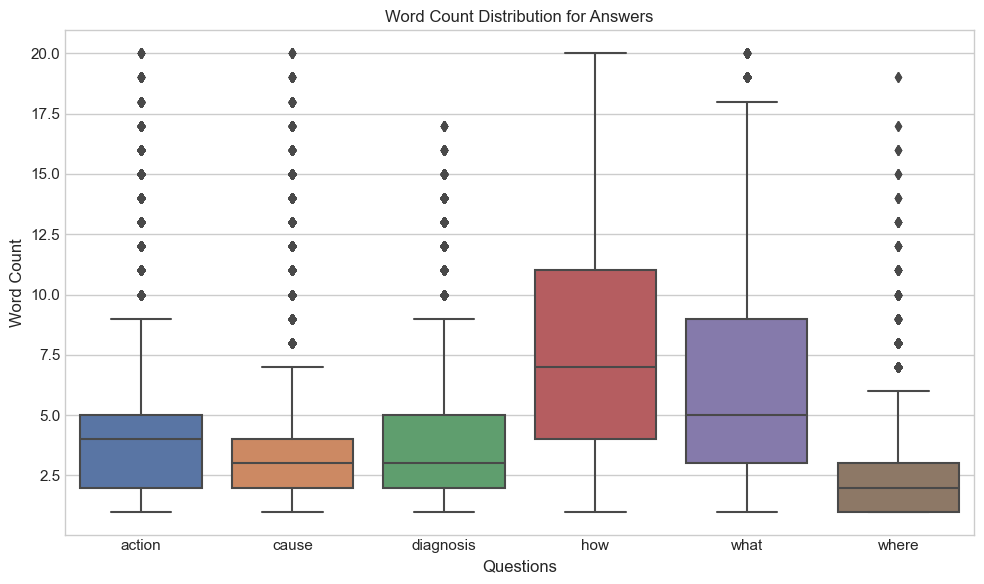

In [21]:
word_counts = questions_df[string_columns] 

word_counts = word_counts.applymap(lambda x: len(str(x).split()))
word_counts.columns = ["word_count_" + col for col in word_counts.columns]

melted_df = word_counts.melt(value_name='word_count', var_name='column_name')
melted_df['column_name'] = melted_df['column_name'].str.replace('word_count_', '')

plt.figure(figsize=(10, 6))
sns.boxplot(x="column_name", y="word_count", data=melted_df)
plt.xlabel("Questions")
plt.ylabel("Word Count")
plt.title("Word Count Distribution for Answers")
plt.tight_layout()
plt.show()

We can see that we have small sentences as answers instead of actual words. This makes it difficult to effectively analyze these answers in relation to the tabular variables we have and generate insights. It would be cool if we could "extract" the main topic covered in each answer... which leads us to topic modelling!

Topic modelling is a technique that allows us to extract topics from large volumes of text. It would allow us, for example, to extract the topic "slip" from many different sentences that contain words related to slipping, which in turn would enable us to perform a more meaningful analysis with information that was extracted from the narratives and is not available on the tabular variables.

There are many algorithms and techniques for topic modelling, but we'll start with the most traditional one: Latent Dirichlet Allocation (LDA). It doesn't use transformers or other deep learning models, which makes it considerably faster to implement and test!

LDA is an unsupervised algorithm. It considers texts as a collection of topics, and each topic as a collection of keywords. Thus, text processing is a fundamental step for the algorithm to achieve a good performance. Before feeding the text to our transformer, we already performed a bit of processing by translating some of the most common medical terms.

The next step is to tokenize the text. We'll use a simple rule that considers strings separated by spaces as tokens. We also remove punctuation and digits:

In [22]:
def tokenize_answers(s):
    return gensim.utils.simple_preprocess(str(s), deacc=True)

lda_df = questions_df[string_columns].copy()
lda_df = lda_df.applymap(tokenize_answers)
lda_df.head()

,action,cause,diagnosis,how,what,where
0,"[falling, to, the, floor]","[floors, or, flooring, materials]","[subdural, hematoma]","[the, patient, fell, to, the, floor, onto, its...","[subdural, hematoma]","[at, the, nursing, home]"
1,"[falling, in, the, shower]","[the, things, involved, in, the, accident, wer...","[the, patient, has, broken, skull]","[the, patient, fell, in, the, shower]","[the, patient, suffered, internal, injury, on,...",[bathtub]
2,"[getting, up]","[sofas, couches, davenports, divans, or, studi...","[hemorrhagic, stroke]","[the, patient, was, getting, up, from, the, co...","[abrasions, to, elbows, admitted, for, hemorrh...","[the, floor]"
3,"[falling, on, the, floor]","[slipped, on, water]","[right, radius, fracture]","[the, patient, slipped, on, water]","[fractured, its, right, arm]","[on, the, floor]"
4,"[standing, on, step, stool]","[step, stools]","[right, radius, fracture]","[the, patient, was, standing, on, step, stool,...","[fractured, its, right, arm]","[on, the, lower, arm]"


Now we can remove stop words, which are basically words that have mostly grammatical purpose. Since we're topics are made of keywords and stop words are very frequent, it's a good idea to remove them in order to avoid topics made entirely of words like "a", "the", etc.

It is usually a good idea to also add words that are very common on our texts as stop words. I do not do that and only use the default English stop words, but it could be useful to remove words like "fall" and "get", which usually appear in our answers. As we'll see in the next cells (spoilers!), some topics will have these words as keywords, which make them a bit confusing. The "fall" word is especially problematic because due to the fact that so many of our sentences have this word, it makes it so that most instances are clustered into one big topic because of this word!

In [23]:
stop_words = stopwords.words('english')
#stop_words.extend(["fell", "fall", "get", "got", "getting"])

lda_df = lda_df.applymap(lambda x: [w for w in x if w not in stop_words])

lda_df.head()

,action,cause,diagnosis,how,what,where
0,"[falling, floor]","[floors, flooring, materials]","[subdural, hematoma]","[patient, fell, floor, onto, back, head]","[subdural, hematoma]","[nursing, home]"
1,"[falling, shower]","[things, involved, accident, bathtubs, showers]","[patient, broken, skull]","[patient, fell, shower]","[patient, suffered, internal, injury, head]",[bathtub]
2,[getting],"[sofas, couches, davenports, divans, studio, c...","[hemorrhagic, stroke]","[patient, getting, couch, fell, floor, sustain...","[abrasions, elbows, admitted, hemorrhagic, str...",[floor]
3,"[falling, floor]","[slipped, water]","[right, radius, fracture]","[patient, slipped, water]","[fractured, right, arm]",[floor]
4,"[standing, step, stool]","[step, stools]","[right, radius, fracture]","[patient, standing, step, stool, fell]","[fractured, right, arm]","[lower, arm]"


We use bigrams and trigrams (expressions that are a combination of 2 words and 3 words, respectively) in order to group together expressions that are usually coupled together as only one word:

In [24]:
def make_ngrams(text, ngram_model):
    return ngram_model[text]

for col in string_columns:
    answers_from_col = lda_df[col].values
    
    # analyze and create bigrams
    bigram = gensim.models.Phrases(answers_from_col, min_count=2, threshold=5)
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    # analyze and create trigrams
    trigram = gensim.models.Phrases(bigram[answers_from_col], threshold=100)
    trigram_model = gensim.models.phrases.Phraser(trigram)

    # apply bigrams
    lda_df[col] = lda_df[col].apply(lambda x: make_ngrams(x, bigram_model))
    
    # apply trigrams
    lda_df[col] = lda_df[col].apply(lambda x: make_ngrams(x, trigram_model))
    
    
lda_df.head()

,action,cause,diagnosis,how,what,where
0,"[falling, floor]","[floors, flooring, materials]","[subdural, hematoma]","[patient, fell, floor, onto, back, head]",[subdural_hematoma],"[nursing, home]"
1,"[falling, shower]","[things_involved_accident, bathtubs_showers]","[patient_broken, skull]","[patient, fell, shower]","[patient_suffered, internal_injury_head]",[bathtub]
2,[getting],"[sofas_couches, davenports_divans, studio_couc...",[hemorrhagic_stroke],"[patient, getting, couch, fell, floor, sustain...","[abrasions_elbows, admitted, hemorrhagic, stroke]",[floor]
3,"[falling, floor]","[slipped, water]","[right, radius, fracture]","[patient, slipped, water]","[fractured, right, arm]",[floor]
4,"[standing, step_stool]","[step, stools]","[right, radius, fracture]","[patient, standing, step_stool, fell]","[fractured, right, arm]","[lower, arm]"


Cool, now the only thing left to do is to lemmatize the words present in our answers. This basically turns "inflections" of words into a single word, e.g. "slipped", "slipping", "slip" all turn into "slip".

In [25]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize(text):
    # only keep certain kinds of words
    allowed_tags = ["NOUN", "ADJ", "VERB", "ADV"]
    
    text = nlp(" ".join(text)) 
    text = [token.lemma_ for token in text if token.pos_ in allowed_tags]

    return text

lda_df = lda_df.applymap(lemmatize)
lda_df.head()


,action,cause,diagnosis,how,what,where
0,"[fall, floor]","[floor, floor, material]",[],"[fall, floor, back, head]",[],"[nursing, home]"
1,"[fall, shower]",[bathtubs_shower],[skull],"[fall, shower]",[],[]
2,[get],"[sofas_couche, davenports_divan, studio_couche...",[],"[patient, get, couch, fall, floor, sustained, ...","[abrasions_elbow, admit, hemorrhagic, stroke]",[floor]
3,"[fall, floor]","[slip, water]","[right, radius, fracture]","[slip, water]","[fractured, right, arm]",[floor]
4,"[stand, step_stool]","[step, stool]","[right, radius, fracture]","[stand, fall]","[fractured, right, arm]","[low, arm]"


With the processing done we can create our LDA model! We start by defining the inputs. Note that we have multiple corpora (one corpus for each type of answer column):

In [26]:
lda_df["cpsc_case_number"] = questions_df["cpsc_case_number"]
lda_df = lda_df.sample(frac=1, random_state=SEED)
lda_df.head()

,action,cause,diagnosis,how,what,where,cpsc_case_number
72590,"[fall, bed]",[bedframe],"[close, fracture, distal_end, right, ulna]","[mechanical, fall]","[break, bone, arm]",[bed],211225577
1121,"[fall, floor]","[floor, material]",[head],"[fall, floor]","[fall, floor]",[floor],190140881
71713,"[wheelchair, bed]","[wheelchair, bed]",[fracture],"[patient, wheelchair, bed, fall, floor]","[fall, floor]",[floor],211200724
72592,[walk],"[floor, material]","[facial, contusion]","[fall, floor]","[fall, floor]",[floor],211225611
56603,"[slip, floor]","[floor, floor, material]","[contusion, low, arm]","[slip, floor, injure, lower_arm]","[fall, floor]",[floor],210500604


In [27]:
lda_input = {}

for col in string_columns:
    # create dictionary
    id2word = corpora.Dictionary(lda_df[col].values)
    
    # create corpus
    texts = lda_df[col].values
    corpus = [id2word.doc2bow(text) for text in texts]

    lda_input[col] = (corpus, id2word)
    
lda_input.keys()

dict_keys(['action', 'cause', 'diagnosis', 'how', 'what', 'where'])

And now we can train our model and visualize the results. Here we'll be considering only the model for the `cause` column for demonstration purposes:

In [28]:
for col, (corpus, id2word) in lda_input.items():
    if col != "cause":
        continue
    
    print(col)
    
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=10,
        alpha="auto",
        per_word_topics=True
    )
    
    print("perplexity:", lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lda_df[col].values, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("coherence score:", coherence_lda)
    
    break

cause
perplexity: -4.491528298168397
coherence score: 0.6445158018228228


We can see how our topics are clustered:

In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.385495 -0.080476       1        1  33.538210
6     -0.163030 -0.304968       2        1  12.912293
7     -0.059152  0.155996       3        1  12.861723
1     -0.065855  0.148285       4        1   8.138119
2     -0.082901 -0.001535       5        1   6.900460
8     -0.061111  0.144301       6        1   6.701319
0     -0.170094 -0.261318       7        1   6.176175
3     -0.061362  0.133157       8        1   4.361040
5      0.338389 -0.058357       9        1   4.250647
4     -0.060380  0.124914      10        1   4.160015, topic_info=            Term          Freq         Total Category  logprob  loglift
1          floor  46369.000000  46369.000000  Default  30.0000  30.0000
2       material  24010.000000  24010.000000  Default  29.0000  29.0000
0       bedframe   9712.000000   9712.000000  Default  28.0000  28.0000
9           step   9256.000000   9256.000000  Default  27.0000  27.0000
8          stair   8536.000000   8536.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
153  plastic_bag     52.190073     53.139989  Topic10  -5.1330   3.1616
826         desk     49.076257     50.026222  Topic10  -5.1945   3.1605
167          toe     47.665785     48.615727  Topic10  -5.2237   3.1599
173     weakness     47.341746     48.291688  Topic10  -5.2305   3.1598
242         pick     46.014524     46.964493  Topic10  -5.2589   3.1592

[340 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
190       8  0.995723             abrasion
234       6  0.993907             accident
389       8  0.961114              alcohol
301       1  0.989318                  arm
255       9  0.981678  atrial_fibrillation
...     ...       ...                  ...
87        4  0.991960         window_glass
637       3  0.993463          window_sill
750       4  0.985779                 wine
854       2  0.977862                 wood
31        5  0.983509               wooden

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 8, 2, 3, 9, 1, 4, 6, 5])

That's cool, and we were already able to create some topics related to certain info that we wouldn't be able to extract directly from the tabular variables. On top of that, most of the main topics are already well separated! However, we can make the model much better if we optimize some of its parameters.

## 2.3 Hyperparameter search on data processing & LDA

We're going to use hyperparameter optimization in order to find the best model. However, we're going to do it a bit differently:

1. Since we're using an unsupervised model to infer the topics, we will not have any kind of cross-validation, since there is no way to actually validate our model. We'll be using metrics that compute how good the model is though.

2. Due to the fact that the processing we do beforehand on our data plays such a crucial role in the effectiveness of the model, we'll also be exploring different data processing hyperparameters. Note that there are two VERY BIG "hyperparameters" that influence our model: the questions we asked and the transformer model we used. Due to the high computational cost of inferring on our dataset with transformers, we'll not be exploring these aspects of our approach.

3. We are asking many questions to our model, and each question will have different answer topics. As such, we'll be exploring the best data processing AND model hyperparameters for each question, searching for the best data processing and model for each question. This is where the speed of LDA really comes into play, as it allows for these large searches without the need of a GPU! (though this still takes a while, especially because of the lemmatization step)

The following cell describes the objective function that we'll use to optimize our parameters and hyperparameters:

In [30]:
def make_lda_model(col, param_data, param_model):
    # process data
    ## get only string column
    df = questions_df[[col]].copy()
    
    ## tokenize
    df = df.applymap(tokenize_answers)
    
    ## remove stop words
    df = df.applymap(lambda x: [w for w in x if w not in stop_words])
    
    ## create ngrams
    answers_from_col = df[col].values
    
    if param_data["use_bigram"]:
        bigram = gensim.models.Phrases(answers_from_col, min_count=param_data["bigram_min_count"], threshold=param_data["bigram_threshold"])
        bigram_model = gensim.models.phrases.Phraser(bigram)
        df[col] = df[col].apply(lambda x: make_ngrams(x, bigram_model))
    
        if param_data["use_trigram"]:
            trigram = gensim.models.Phrases(bigram[answers_from_col], min_count=param_data["trigram_min_count"], threshold=param_data["trigram_threshold"])
            trigram_model = gensim.models.phrases.Phraser(trigram)
            df[col] = df[col].apply(lambda x: make_ngrams(x, trigram_model))
        
    ## lemmatize (takes a while)
    df = df.applymap(lemmatize)
    
    ## shuffle dataframe and add identifying number
    df["cpsc_case_number"] = questions_df["cpsc_case_number"]
    df = df.sample(frac=1, random_state=SEED)
    
    ## create LDA input
    id2word = corpora.Dictionary(df[col].values)
    texts = df[col].values
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # train model
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        update_every=1,
        alpha="auto",
        per_word_topics=True,
        random_state=SEED,
        **param_model
    )
    
    # return data used for the model
    data = (corpus, id2word, df)
    
    return lda_model, data

def objective(trial, col):
    param_grid_data = {
        "use_bigram": trial.suggest_categorical("use_bigram", [False, True]),
        "bigram_min_count": trial.suggest_int("bigram_min_count", 1, 10, step=3),
        "bigram_threshold": trial.suggest_int("bigram_threshold", 1, 10, step=3),
        "use_trigram": trial.suggest_categorical("use_trigram", [False, True]),
        "trigram_min_count": trial.suggest_int("trigram_min_count", 10, 100, step=30),
        "trigram_threshold": trial.suggest_int("trigram_threshold", 10, 100, step=30),
    }
    
    param_grid_model = {
        "num_topics": trial.suggest_int("num_topics", 10, 70, step=10),
        "chunksize": trial.suggest_int("chunksize", 500, 2000, step=500),
        "passes": trial.suggest_int("passes", 1, 10, step=3),
    }
    
    # process data and train LDA model
    lda_model, data = make_lda_model(col, param_grid_data, param_grid_model)
    
    # get data that was used in the model (for performance measure purposes)
    corpus, id2word, df = data
    
    # get metrics
    ## perplexity
    #perplexity = lda_model.log_perplexity(corpus)

    ## coherence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df[col].values, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    #return metric
    #return perplexity, coherence_lda
    return coherence_lda

Performance of our model can be computed via the perplexity score and the coherence score:

- Perplexity measures how well the topic model predicts new data. It reflects the generalization of the model, with a low perplexity score meaning that the model is more confident in its predictions.

- Coherence measures how well the words in a topic relate to each other. As the name implies, a high coherence score means that the topic is coherent and consistent, closer to what we would consider a good topic.

Given our use case, coherence is more relevant to us, which means we'll be trying to maximize the coherence score. With that said, by uncommenting the line `return perplexity, coherence_lda` on the previous code cell and the `study = optuna.create_study(directions=["minimize", "maximize"], study_name=f"LDA on `{col}` answers")` in the next cell, we would perform a multi-objective optimization that minimizes the perplexity and maximizes the coherence.

Now we can perform the parameter and hyperparameter search for each of our answers and save the best values. In my original submission I set `n_trials=40`, here I'm setting it to 2 just for demonstration purposes since the best hyperparameters for 40 trials are already available on `data/intermediate/lda_params.json` since this part of the code takes a while.

In [32]:
best_params_lda = {}

for col in string_columns:
    print(f"optimizing for column `{col}`...")
    
    # perform parameter and hyperparameter search (minimize perplexity and maximize coherence)
    #study = optuna.create_study(directions=["minimize", "maximize"], study_name=f"LDA on `{col}` answers")
    study = optuna.create_study(direction="maximize", study_name=f"LDA on `{col}` answers")
    
    func = lambda trial: objective(trial, col)
    """
    study.optimize(func, n_trials=40, n_jobs=4)
    """
    study.optimize(func, n_trials=2, n_jobs=4)
    
    # print results
    print("number of finished trials: ", len(study.trials))
    
    print("best trial:")
    trial = study.best_trial

    print("\tmetric:", trial.value)
    print("\tparams:")
    for key, value in trial.params.items():
        print(f"\t\t{key}: {value}")
        
    # save best parameters
    best_params_lda[col] = trial.params
    """
    with open("../data/intermediate/lda_params.json", "w") as f_lda_params:
        json.dump(best_params_lda, f_lda_params)
    """
    
    print()

[I 2023-11-16 00:59:16,364] A new study created in memory with name: LDA on `action` answers


optimizing for column `action`...


[I 2023-11-16 01:02:28,040] Trial 1 finished with value: 0.5336828501702904 and parameters: {'use_bigram': False, 'bigram_min_count': 7, 'bigram_threshold': 4, 'use_trigram': True, 'trigram_min_count': 70, 'trigram_threshold': 40, 'num_topics': 10, 'chunksize': 1500, 'passes': 4}. Best is trial 1 with value: 0.5336828501702904.
[I 2023-11-16 01:02:55,763] Trial 0 finished with value: 0.5618673826331844 and parameters: {'use_bigram': False, 'bigram_min_count': 10, 'bigram_threshold': 7, 'use_trigram': False, 'trigram_min_count': 40, 'trigram_threshold': 100, 'num_topics': 40, 'chunksize': 2000, 'passes': 10}. Best is trial 0 with value: 0.5618673826331844.
[I 2023-11-16 01:02:55,768] A new study created in memory with name: LDA on `cause` answers


number of finished trials:  2
best trial:
	metric: 0.5618673826331844
	params:
		use_bigram: False
		bigram_min_count: 10
		bigram_threshold: 7
		use_trigram: False
		trigram_min_count: 40
		trigram_threshold: 100
		num_topics: 40
		chunksize: 2000
		passes: 10

optimizing for column `cause`...


[I 2023-11-16 01:05:51,351] Trial 0 finished with value: 0.5219821291196245 and parameters: {'use_bigram': False, 'bigram_min_count': 7, 'bigram_threshold': 4, 'use_trigram': False, 'trigram_min_count': 70, 'trigram_threshold': 10, 'num_topics': 20, 'chunksize': 1000, 'passes': 1}. Best is trial 0 with value: 0.5219821291196245.
[I 2023-11-16 01:06:07,862] Trial 1 finished with value: 0.5011155040884702 and parameters: {'use_bigram': False, 'bigram_min_count': 4, 'bigram_threshold': 10, 'use_trigram': True, 'trigram_min_count': 100, 'trigram_threshold': 40, 'num_topics': 60, 'chunksize': 1500, 'passes': 4}. Best is trial 0 with value: 0.5219821291196245.
[I 2023-11-16 01:06:07,865] A new study created in memory with name: LDA on `diagnosis` answers


number of finished trials:  2
best trial:
	metric: 0.5219821291196245
	params:
		use_bigram: False
		bigram_min_count: 7
		bigram_threshold: 4
		use_trigram: False
		trigram_min_count: 70
		trigram_threshold: 10
		num_topics: 20
		chunksize: 1000
		passes: 1

optimizing for column `diagnosis`...


[I 2023-11-16 01:09:36,647] Trial 0 finished with value: 0.40491545845966276 and parameters: {'use_bigram': True, 'bigram_min_count': 7, 'bigram_threshold': 1, 'use_trigram': True, 'trigram_min_count': 40, 'trigram_threshold': 70, 'num_topics': 70, 'chunksize': 1500, 'passes': 4}. Best is trial 0 with value: 0.40491545845966276.
[I 2023-11-16 01:09:45,585] Trial 1 finished with value: 0.4939659880691878 and parameters: {'use_bigram': False, 'bigram_min_count': 1, 'bigram_threshold': 1, 'use_trigram': False, 'trigram_min_count': 100, 'trigram_threshold': 70, 'num_topics': 30, 'chunksize': 500, 'passes': 4}. Best is trial 1 with value: 0.4939659880691878.
[I 2023-11-16 01:09:45,586] A new study created in memory with name: LDA on `how` answers


number of finished trials:  2
best trial:
	metric: 0.4939659880691878
	params:
		use_bigram: False
		bigram_min_count: 1
		bigram_threshold: 1
		use_trigram: False
		trigram_min_count: 100
		trigram_threshold: 70
		num_topics: 30
		chunksize: 500
		passes: 4

optimizing for column `how`...


[I 2023-11-16 01:12:52,645] Trial 1 finished with value: 0.4036371998690841 and parameters: {'use_bigram': False, 'bigram_min_count': 10, 'bigram_threshold': 4, 'use_trigram': True, 'trigram_min_count': 10, 'trigram_threshold': 70, 'num_topics': 20, 'chunksize': 500, 'passes': 1}. Best is trial 1 with value: 0.4036371998690841.
[I 2023-11-16 01:13:43,422] Trial 0 finished with value: 0.48717849304358196 and parameters: {'use_bigram': False, 'bigram_min_count': 4, 'bigram_threshold': 10, 'use_trigram': False, 'trigram_min_count': 10, 'trigram_threshold': 70, 'num_topics': 60, 'chunksize': 1500, 'passes': 10}. Best is trial 0 with value: 0.48717849304358196.
[I 2023-11-16 01:13:43,423] A new study created in memory with name: LDA on `what` answers


number of finished trials:  2
best trial:
	metric: 0.48717849304358196
	params:
		use_bigram: False
		bigram_min_count: 4
		bigram_threshold: 10
		use_trigram: False
		trigram_min_count: 10
		trigram_threshold: 70
		num_topics: 60
		chunksize: 1500
		passes: 10

optimizing for column `what`...


[I 2023-11-16 01:16:40,205] Trial 0 finished with value: 0.3455611757373782 and parameters: {'use_bigram': True, 'bigram_min_count': 1, 'bigram_threshold': 7, 'use_trigram': False, 'trigram_min_count': 100, 'trigram_threshold': 70, 'num_topics': 50, 'chunksize': 2000, 'passes': 1}. Best is trial 0 with value: 0.3455611757373782.
[I 2023-11-16 01:16:59,864] Trial 1 finished with value: 0.4531004808464475 and parameters: {'use_bigram': False, 'bigram_min_count': 4, 'bigram_threshold': 7, 'use_trigram': False, 'trigram_min_count': 40, 'trigram_threshold': 10, 'num_topics': 70, 'chunksize': 2000, 'passes': 4}. Best is trial 1 with value: 0.4531004808464475.
[I 2023-11-16 01:16:59,869] A new study created in memory with name: LDA on `where` answers


number of finished trials:  2
best trial:
	metric: 0.4531004808464475
	params:
		use_bigram: False
		bigram_min_count: 4
		bigram_threshold: 7
		use_trigram: False
		trigram_min_count: 40
		trigram_threshold: 10
		num_topics: 70
		chunksize: 2000
		passes: 4

optimizing for column `where`...


[I 2023-11-16 01:19:54,736] Trial 1 finished with value: 0.554649855907085 and parameters: {'use_bigram': True, 'bigram_min_count': 1, 'bigram_threshold': 1, 'use_trigram': False, 'trigram_min_count': 10, 'trigram_threshold': 100, 'num_topics': 30, 'chunksize': 1500, 'passes': 4}. Best is trial 1 with value: 0.554649855907085.
[I 2023-11-16 01:19:59,846] Trial 0 finished with value: 0.6696591773097103 and parameters: {'use_bigram': True, 'bigram_min_count': 1, 'bigram_threshold': 10, 'use_trigram': True, 'trigram_min_count': 70, 'trigram_threshold': 10, 'num_topics': 10, 'chunksize': 1000, 'passes': 7}. Best is trial 0 with value: 0.6696591773097103.


number of finished trials:  2
best trial:
	metric: 0.6696591773097103
	params:
		use_bigram: True
		bigram_min_count: 1
		bigram_threshold: 10
		use_trigram: True
		trigram_min_count: 70
		trigram_threshold: 10
		num_topics: 10
		chunksize: 1000
		passes: 7



The actual values obtained with `n_trials=40` are the following:

```
optimizing for column `action`...
best trial:
	metric: 0.6588814985835116
	params:
		use_bigram: True
		bigram_min_count: 1
		bigram_threshold: 1
		use_trigram: False
		trigram_min_count: 100
		trigram_threshold: 70
		num_topics: 10
		chunksize: 1500
		passes: 10

optimizing for column `cause`...
best trial:
	metric: 0.6314309005016373
	params:
		use_bigram: True
		bigram_min_count: 10
		bigram_threshold: 7
		use_trigram: True
		trigram_min_count: 70
		trigram_threshold: 100
		num_topics: 10
		chunksize: 2000
		passes: 10

optimizing for column `diagnosis`...
best trial:
	metric: 0.5425604773168377
	params:
		use_bigram: True
		bigram_min_count: 1
		bigram_threshold: 1
		use_trigram: False
		trigram_min_count: 70
		trigram_threshold: 70
		num_topics: 30
		chunksize: 500
		passes: 4

optimizing for column `how`...
best trial:
	metric: 0.5859226139343998
	params:
		use_bigram: True
		bigram_min_count: 1
		bigram_threshold: 4
		use_trigram: False
		trigram_min_count: 40
		trigram_threshold: 70
		num_topics: 30
		chunksize: 1000
		passes: 10

optimizing for column `what`...
best trial:
	metric: 0.5512450086556585
	params:
		use_bigram: True
		bigram_min_count: 10
		bigram_threshold: 10
		use_trigram: True
		trigram_min_count: 40
		trigram_threshold: 100
		num_topics: 30
		chunksize: 2000
		passes: 10

optimizing for column `where`...
best trial:
	metric: 0.7221399263666953
	params:
		use_bigram: True
		bigram_min_count: 4
		bigram_threshold: 1
		use_trigram: True
		trigram_min_count: 40
		trigram_threshold: 100
		num_topics: 10
		chunksize: 1500
		passes: 10
```

Load best parameters after optimization:

In [33]:
with open("../data/intermediate/lda_params.json", "r") as f_lda_params:
    best_params_lda = json.load(f_lda_params)
    
best_params_lda

{'action': {'use_bigram': True,
  'bigram_min_count': 1,
  'bigram_threshold': 1,
  'use_trigram': False,
  'trigram_min_count': 100,
  'trigram_threshold': 70,
  'num_topics': 10,
  'chunksize': 1500,
  'passes': 10},
 'cause': {'use_bigram': True,
  'bigram_min_count': 10,
  'bigram_threshold': 7,
  'use_trigram': True,
  'trigram_min_count': 70,
  'trigram_threshold': 100,
  'num_topics': 10,
  'chunksize': 2000,
  'passes': 10},
 'diagnosis': {'use_bigram': True,
  'bigram_min_count': 1,
  'bigram_threshold': 1,
  'use_trigram': False,
  'trigram_min_count': 70,
  'trigram_threshold': 70,
  'num_topics': 30,
  'chunksize': 500,
  'passes': 4},
 'how': {'use_bigram': True,
  'bigram_min_count': 1,
  'bigram_threshold': 4,
  'use_trigram': False,
  'trigram_min_count': 40,
  'trigram_threshold': 70,
  'num_topics': 30,
  'chunksize': 1000,
  'passes': 10},
 'what': {'use_bigram': True,
  'bigram_min_count': 10,
  'bigram_threshold': 10,
  'use_trigram': True,
  'trigram_min_count': 4

Now that we have the best parameters, we can use the `make_lda_model` function to train the best models for each question. We'll also store the data used in the models in order for us to be able to visualize how the topics were distributed and also to get the topics for each sentence:

In [34]:
best_models = {}

for col in tqdm(string_columns):
    all_params = best_params_lda[col]
    
    # the parameter keys are all together, so we need to separate them (hacky way but it works)
    i_num_topics = list(all_params.keys()).index("num_topics")
    param_data = {key: all_params[key] for key in list(all_params.keys())[:i_num_topics]}
    param_model = {key: all_params[key] for key in list(all_params.keys())[i_num_topics:]}
    
    lda_model, data = make_lda_model(col, param_data, param_model)
    
    best_models[col] = (lda_model, data)

100%|██████████| 6/6 [15:34<00:00, 155.71s/it]


For a comparison, we can see how the new `cause` LDA model compares with the old one:

In [35]:
col = "cause"

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_models[col][0], best_models[col][1][0], best_models[col][1][1])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.383772  0.078507       1        1  32.566102
1     -0.168426  0.307731       2        1  10.809893
0     -0.071984 -0.142353       3        1  10.361489
8     -0.067996 -0.120698       4        1   9.966159
9     -0.063160 -0.115705       5        1   8.107831
4     -0.163679  0.291111       6        1   7.378924
5     -0.065753 -0.117168       7        1   7.280644
7     -0.068026 -0.133764       8        1   6.255727
6     -0.059841 -0.106764       9        1   4.431475
3      0.345092  0.059102      10        1   2.841754, topic_info=          Term          Freq         Total Category  logprob  loglift
1        floor  46695.000000  46695.000000  Default  30.0000  30.0000
2     material  24363.000000  24363.000000  Default  29.0000  29.0000
9         step   9460.000000   9460.000000  Default  28.0000  28.0000
0     bedframe   9788.000000   9788.000000  Default  27.0000  27.0000
8        stair   8584.000000   8584.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
441       bowl     38.520386     39.441790  Topic10  -5.0896   3.5371
762     handle     35.787376     36.708692  Topic10  -5.1632   3.5353
1479    change     34.319406     35.240751  Topic10  -5.2050   3.5343
641   umbrella     33.617534     34.538841  Topic10  -5.2257   3.5337
1        floor   1559.546012  46695.990458  Topic10  -1.3886   0.1615

[335 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
79        4  0.994533          abrasion
250       9  0.994917          accident
129       6  0.996528           alcohol
529       6  0.988484             ankle
609       5  0.992538               arm
...     ...       ...               ...
371       8  0.994629            window
95        8  0.987594      window_glass
314       8  0.981487              wine
36        9  0.989381            wooden
170       1  0.982637  wooden_container

[305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 9, 10, 5, 6, 8, 7, 4])

## 2.4 Getting the topics for each narrative

Now we can extract the topics for each narrative. Note that different LDA models for different questions were optimized with a different amount of topics, some with more and some with less. We'll only be getting the most relevant topic for each narrative, but we could get for example the top 3 topic categories in order to develop a more detailed analysis of both our model and the topics:

In [38]:
for col, pack in best_models.items():
    lda_model, (corpus, id2word, df) = pack
    
    topic_list = {"topic": []} #, "topic_1": [], "topic_2": []}
    keywords_list = {"keywords": []} #, "keywords_1": [], "keywords_2": []}
    score_list = {"score": []} #, "score_1": [], "score_2": []}
    
    # iterate over all narratives
    for row in lda_model[corpus]:
        # sort topics so that the one with highest score is first
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        for i, (topic, score) in enumerate(row):
            # get main topic (topic with largest score)
            if i == 0: # we could use `i < 3` in order to get the top 3 topics
                keywords = lda_model.show_topic(topic)
                keywords = ", ".join([word for word, word_score in keywords])
                
                topic_list[f"topic"].append(topic)
                keywords_list[f"keywords"].append(keywords)
                score_list[f"score"].append(score)

            else:
                break
    
    # update dataframe with results
    for t, k, s in zip(topic_list, keywords_list, score_list):
        df[t] = topic_list[t]
        df[k] = keywords_list[k]
        df[s] = score_list[s]
        
    # save dataframe
    df.to_csv(f"../data/intermediate/lda_dataframes/lda_{col}.csv", index=False)

With each column's dataframe with the main topics, keywords and scores we setup our analysis dataframe.

# 3. Exploring the data using LDA topics and tabular variables

We can start by unifying everything into one big dataframe so that our analysis is easier. We can first load the topics and keywords:

In [39]:
lda_dfs = {df_path.split("_")[-1].split(".")[0]: pd.read_csv(df_path) for df_path in glob("../data/intermediate/lda_dataframes/*.csv")}

And then combine them all with the main dataframe:

In [40]:
# merge LDA dataframes with questions dataframe
for col, df in lda_dfs.items():
    df.rename(columns={col: f"{col}_processed"}, inplace=True)
    df_merged = df.merge(questions_df[["cpsc_case_number", col]], on="cpsc_case_number", how="left")
    
    df_merged.rename(columns={col: f"{col}_answer"}, inplace=True)
    df_merged.rename(columns={"topic": f"{col}_topic"}, inplace=True)
    df_merged.rename(columns={"keywords": f"{col}_keywords"}, inplace=True)
    df_merged.rename(columns={"score": f"{col}_score"}, inplace=True)
    
    # order columns nicely
    df_merged = df_merged[["cpsc_case_number", f"{col}_answer", f"{col}_processed", f"{col}_topic", f"{col}_score", f"{col}_keywords"]]
    
    lda_dfs[col] = df_merged

# merge all LDA dataframes
dfs = [df for df in lda_dfs.values()]

topics = dfs[0]
for df in dfs[1:]:
    topics = pd.merge(topics, df, on="cpsc_case_number", how="outer")

# merge everything with the primary dataframe
analysis = primary.merge(topics, on="cpsc_case_number", how="left")

analysis.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,what_answer,what_processed,what_topic,what_score,what_keywords,how_answer,how_processed,how_topic,how_score,how_keywords
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,subdural hematoma,[],28,0.371097,"fall, floor, suffer, hard, ice, blanket, also,...",The patient fell to the floor onto its back o...,"['fall', 'floor', 'back', 'head']",26,0.417852,"fall, floor, syncopal_event, upper_trunk, put,..."
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,The patient suffered internal injury on its h...,"['suffer', 'internal_injury_head']",28,0.322896,"fall, floor, suffer, hard, ice, blanket, also,...",The patient fell in the shower.,"['fall', 'shower']",26,0.399145,"fall, floor, syncopal_event, upper_trunk, put,..."
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,abrasions to elbows admitted for hemorrhagic ...,"['abrasion', 'elbow', 'admit', 'hemorrhagic', ...",28,0.220361,"fall, floor, suffer, hard, ice, blanket, also,...",The patient was getting up from the couch and ...,"['patient', 'get', 'couch', 'fall', 'floor', '...",26,0.382389,"fall, floor, syncopal_event, upper_trunk, put,..."
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,fractured its right arm,"['fractured', 'right', 'arm']",2,0.265740,"right, fractured, wrist, injury, femur, humeru...",The patient slipped on water,"['slip', 'water']",26,0.285286,"fall, floor, syncopal_event, upper_trunk, put,..."
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,fractured its right arm,"['fractured', 'right', 'arm']",2,0.265561,"right, fractured, wrist, injury, femur, humeru...",The patient was standing on a step stool and ...,"['stand', 'fall']",26,0.399146,"fall, floor, syncopal_event, upper_trunk, put,..."


We can also create a summarized version of the keywords in each topic so that our visualization can be clearer:

In [41]:
keywords_columns = [c for c in analysis.columns if "keywords" in c]
analysis[[c+"_summarized" for c in keywords_columns]] = analysis[keywords_columns].applymap(lambda x: ",".join(x.split(",")[:4]))
analysis.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,how_processed,how_topic,how_score,how_keywords,where_keywords_summarized,diagnosis_keywords_summarized,cause_keywords_summarized,action_keywords_summarized,what_keywords_summarized,how_keywords_summarized
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,"['fall', 'floor', 'back', 'head']",26,0.417852,"fall, floor, syncopal_event, upper_trunk, put,...","bed, nursing, home, get","fracture, hip, clavicle, upper_trunk","floor, material, paper_product, bench","fall, chair, step, wheelchair","fall, floor, suffer, hard","fall, floor, syncopal_event, upper_trunk"
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,"['fall', 'shower']",26,0.399145,"fall, floor, syncopal_event, upper_trunk, put,...","floor, kitchen, door, backwards","fracture, hip, clavicle, upper_trunk","slip, rugs_carpet, ceilings_wall, bathtubs_shower","fall, chair, step, wheelchair","fall, floor, suffer, hard","fall, floor, syncopal_event, upper_trunk"
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,"['patient', 'get', 'couch', 'fall', 'floor', '...",26,0.382389,"fall, floor, syncopal_event, upper_trunk, put,...","floor, kitchen, door, backwards","fracture, hip, clavicle, upper_trunk","carpet, dog, couch, sofas_couche","get, bed, go, dizzy","fall, floor, suffer, hard","fall, floor, syncopal_event, upper_trunk"
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,"['slip', 'water']",26,0.285286,"fall, floor, syncopal_event, upper_trunk, put,...","floor, kitchen, door, backwards","fracture, femur, radius, vertebra","slip, rugs_carpet, ceilings_wall, bathtubs_shower","fall, chair, step, wheelchair","right, fractured, wrist, injury","fall, floor, syncopal_event, upper_trunk"
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,"['stand', 'fall']",26,0.399146,"fall, floor, syncopal_event, upper_trunk, put,...","chair, bathroom, kitchen, ladder","fracture, femur, radius, vertebra","step, stair, recliner_chair, go","fall, chair, step, wheelchair","right, fractured, wrist, injury","fall, floor, syncopal_event, upper_trunk"


Now we can begin our analysis!

## 3.1 EDA of topics

We could begin our EDA by exploring some of the tabular variables by themselves in order to get some ideas about what's going on. However, since the "special" part of this approach is the creation of topics, we'll be focusing on the topics and how we could use them to extract insights.

Initially, we can create a countplot that shows us the distribution of a variable by another variable so that we can see how they are distributed:

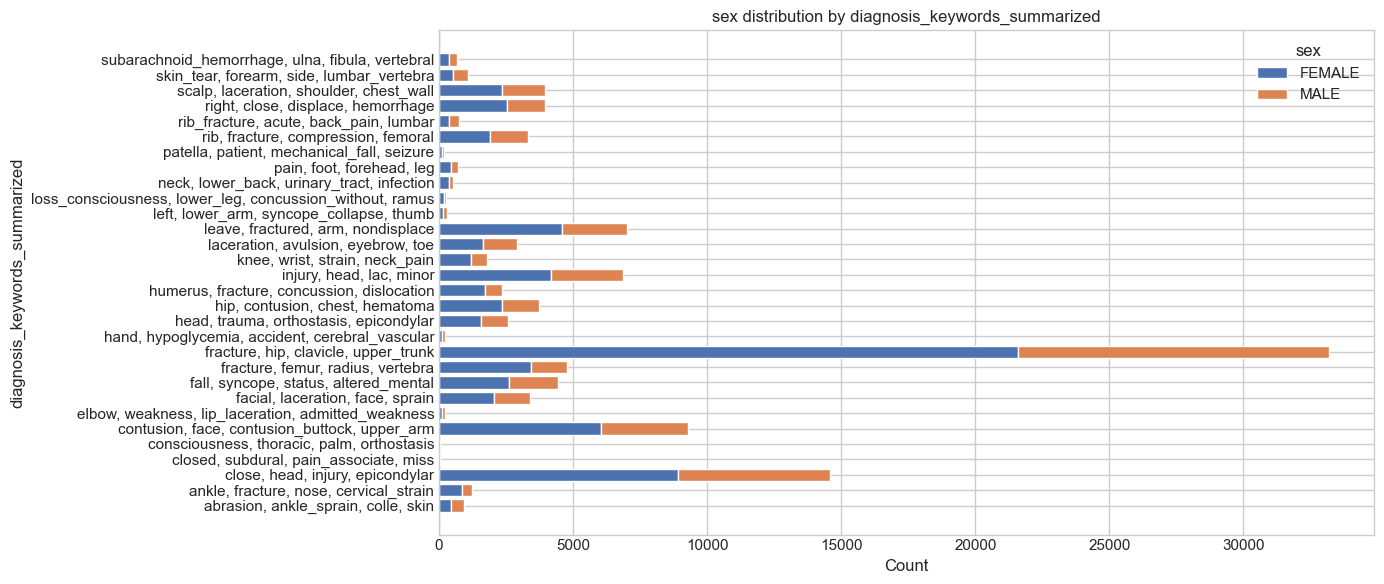

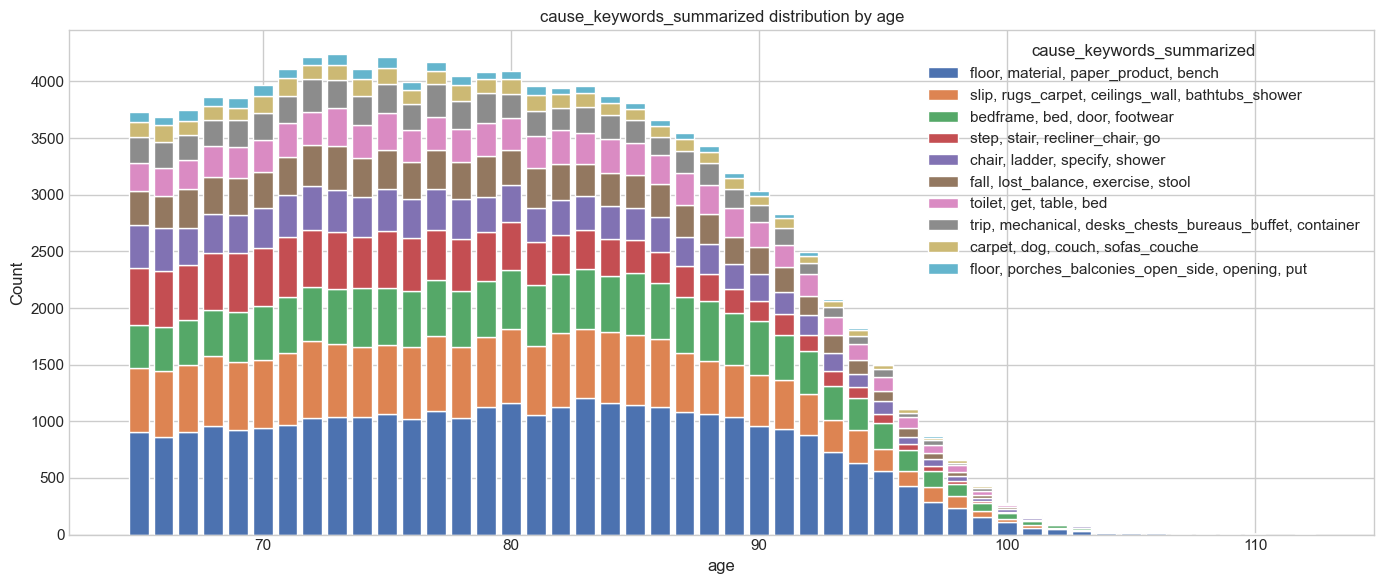

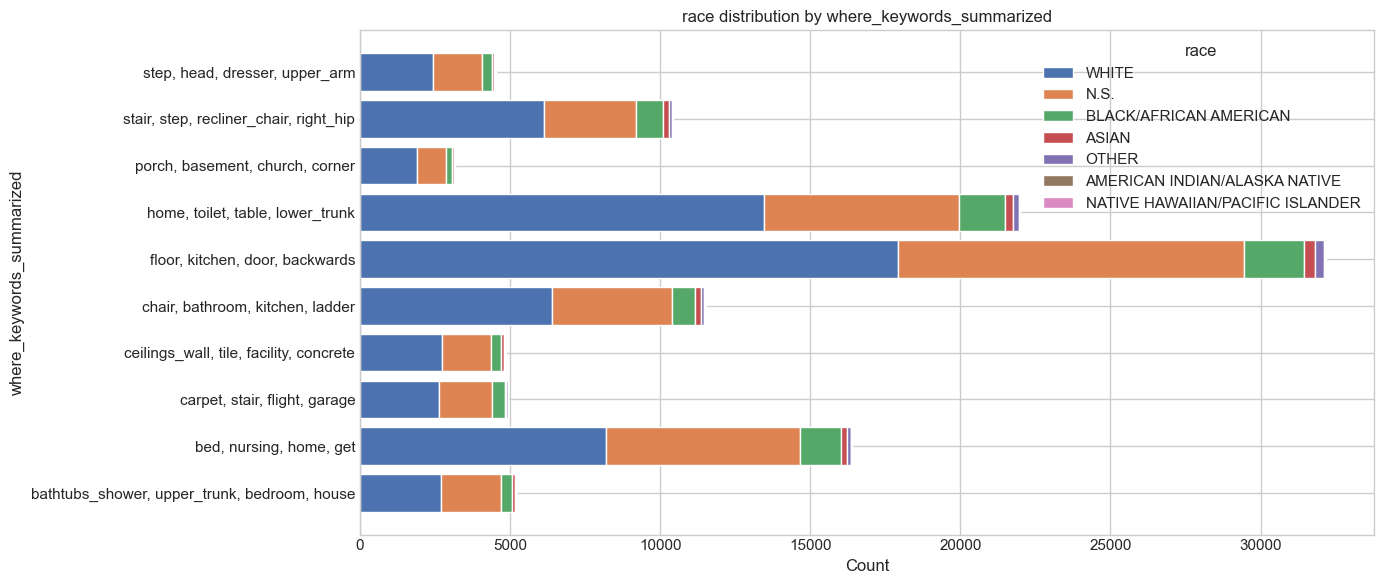

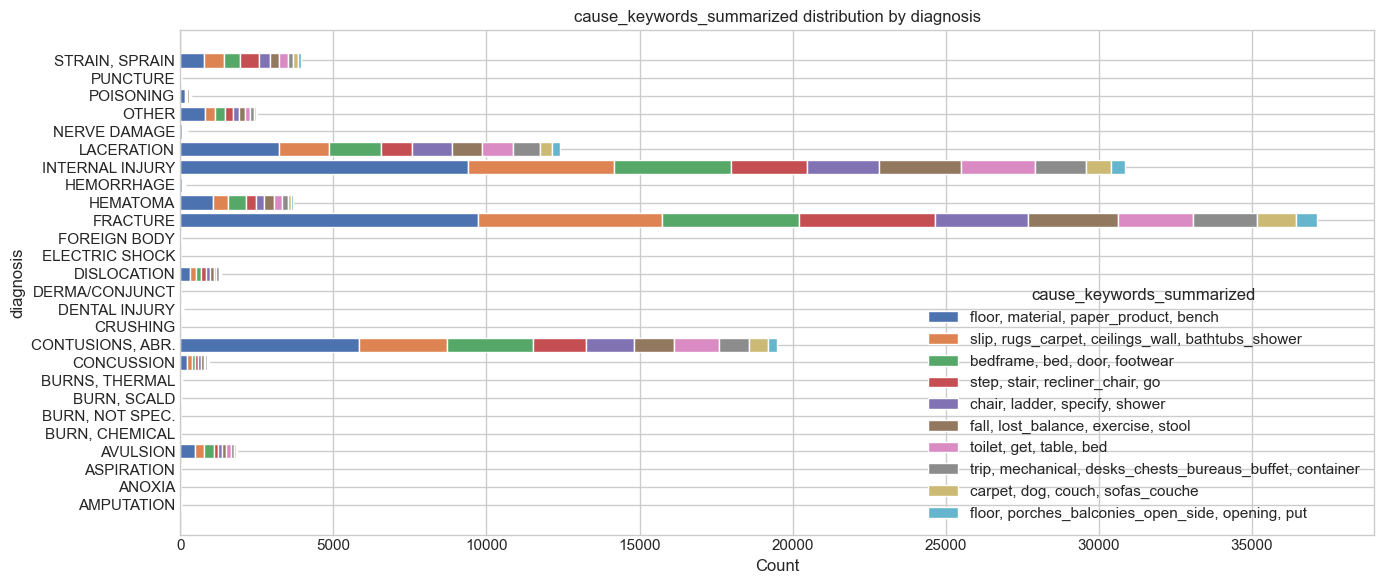

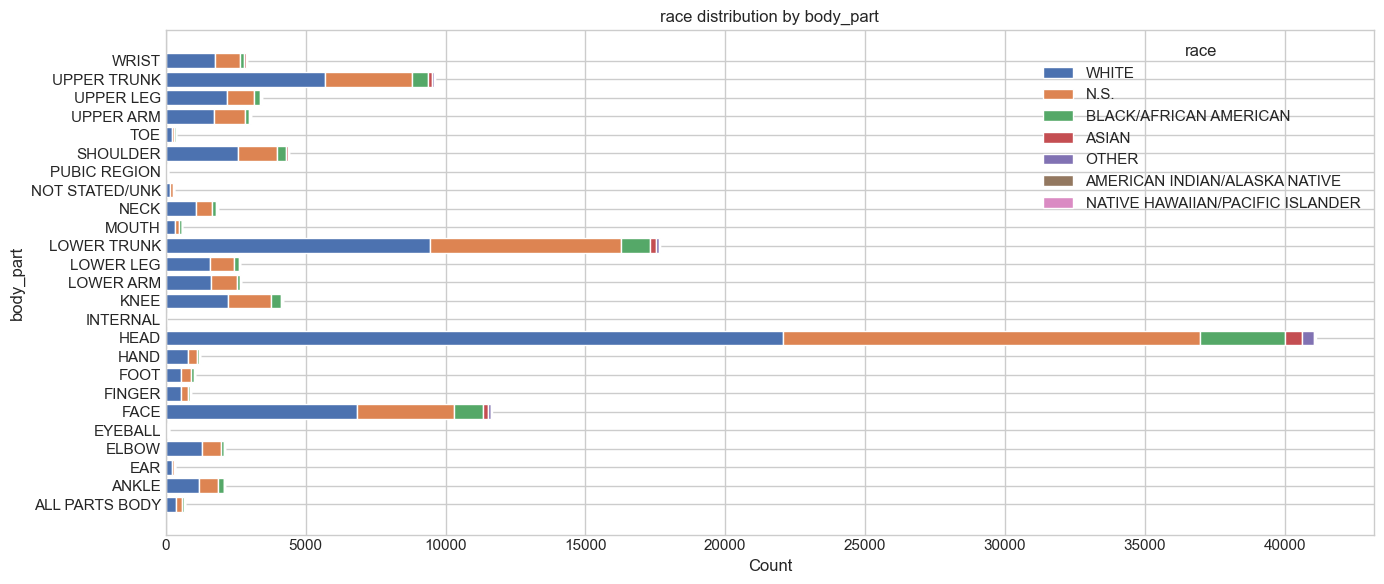

In [42]:
def plot_countplot_distribution_by(distribution, by, horizontal):
    plt.figure(figsize=(14, 6))

    # preprocess data to get counts per groups
    count_data = analysis.groupby([by, distribution]).size().reset_index(name="count")
    
    # get most frequent categories to be at the bottom
    desired_order = list(analysis[distribution].value_counts().to_dict().keys())

    # pivot data
    pivot_data = count_data.pivot(index=by, columns=distribution, values="count").fillna(0)
    pivot_data = pivot_data[desired_order]

    # create a stacked countplot-like plot
    bottom = None
    for topic in pivot_data.columns:
        if horizontal:
            plt.barh(pivot_data.index, pivot_data[topic], label=topic, left=bottom)
        else:
            plt.bar(pivot_data.index, pivot_data[topic], label=topic, bottom=bottom)
        if bottom is None:
            bottom = pivot_data[topic]
        else:
            bottom += pivot_data[topic]

    # tidy plot
    if horizontal:
        plt.xlabel("Count")
        plt.ylabel(by)
    else:
        plt.xlabel(by)
        #plt.xticks(rotation=90)
        plt.ylabel("Count")
        
    plt.title(f"{distribution} distribution by {by}")

    plt.legend(title=distribution)
    plt.tight_layout()
    plt.show()
    
plot_countplot_distribution_by(distribution="sex", by="diagnosis_keywords_summarized", horizontal=True)
plot_countplot_distribution_by(distribution="cause_keywords_summarized", by="age", horizontal=False)
plot_countplot_distribution_by(distribution="race", by="where_keywords_summarized", horizontal=True)
plot_countplot_distribution_by(distribution="cause_keywords_summarized", by="diagnosis", horizontal=True)
plot_countplot_distribution_by(distribution="race", by="body_part", horizontal=True)

We can also create a heatmap of two different variables in order to see how the number are distributed:

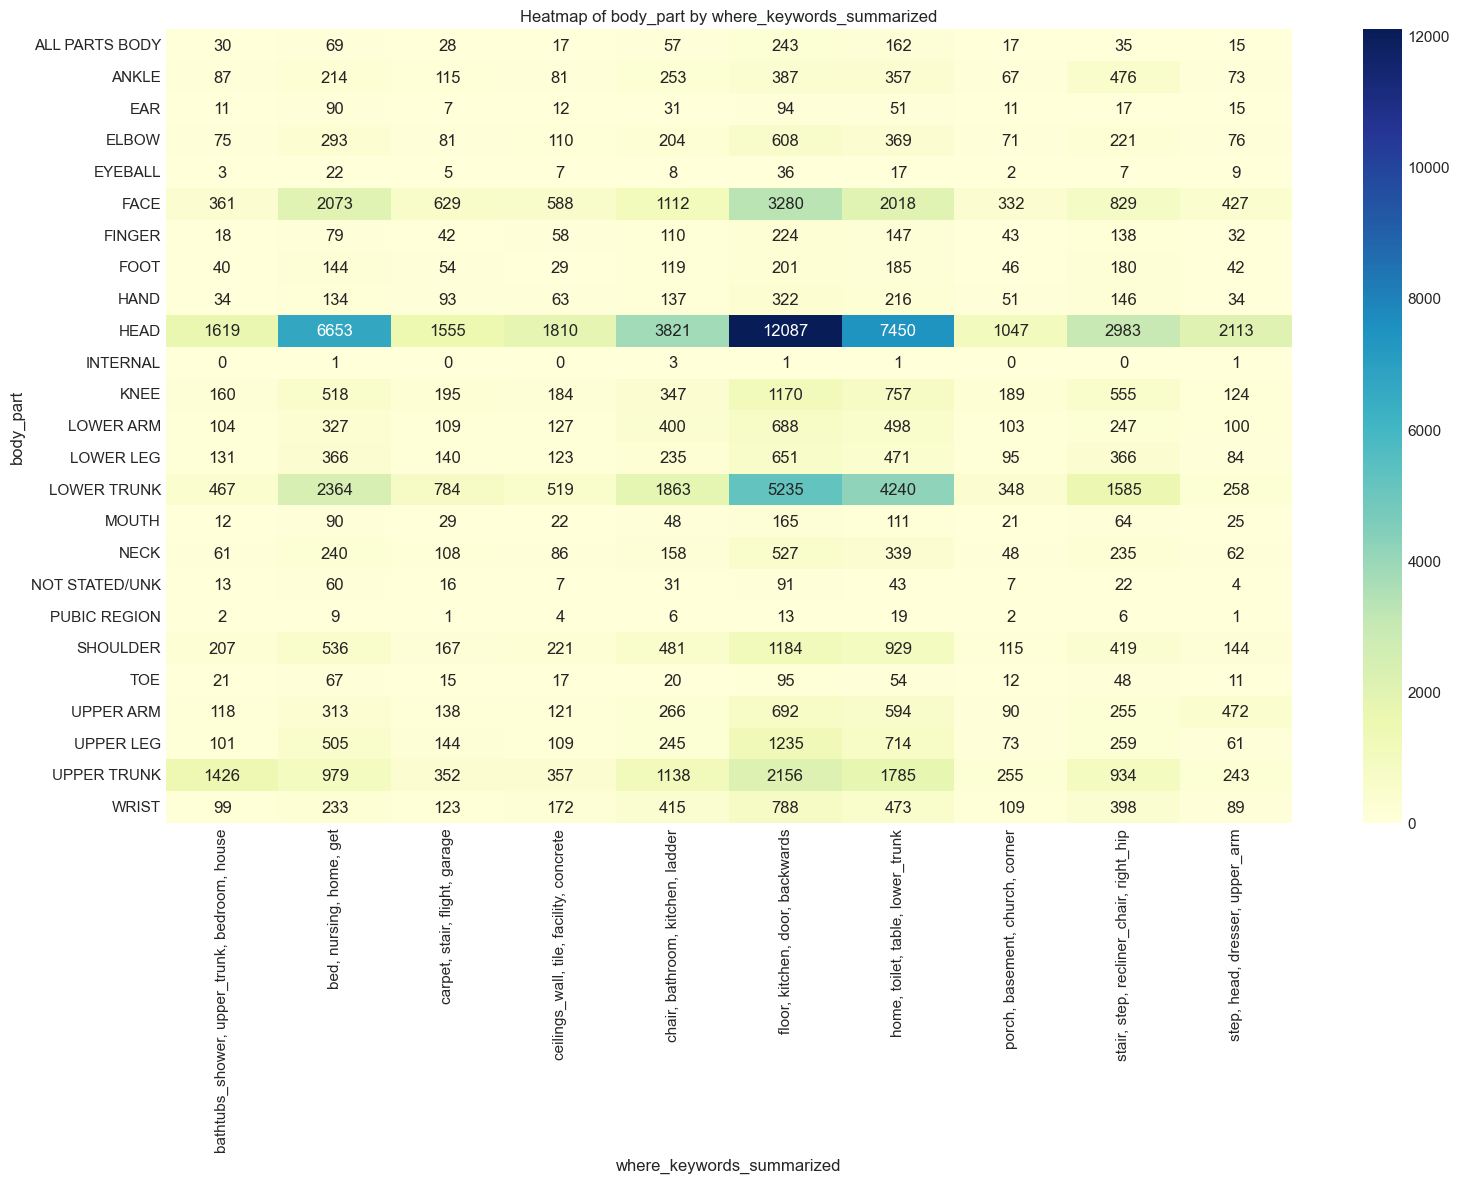

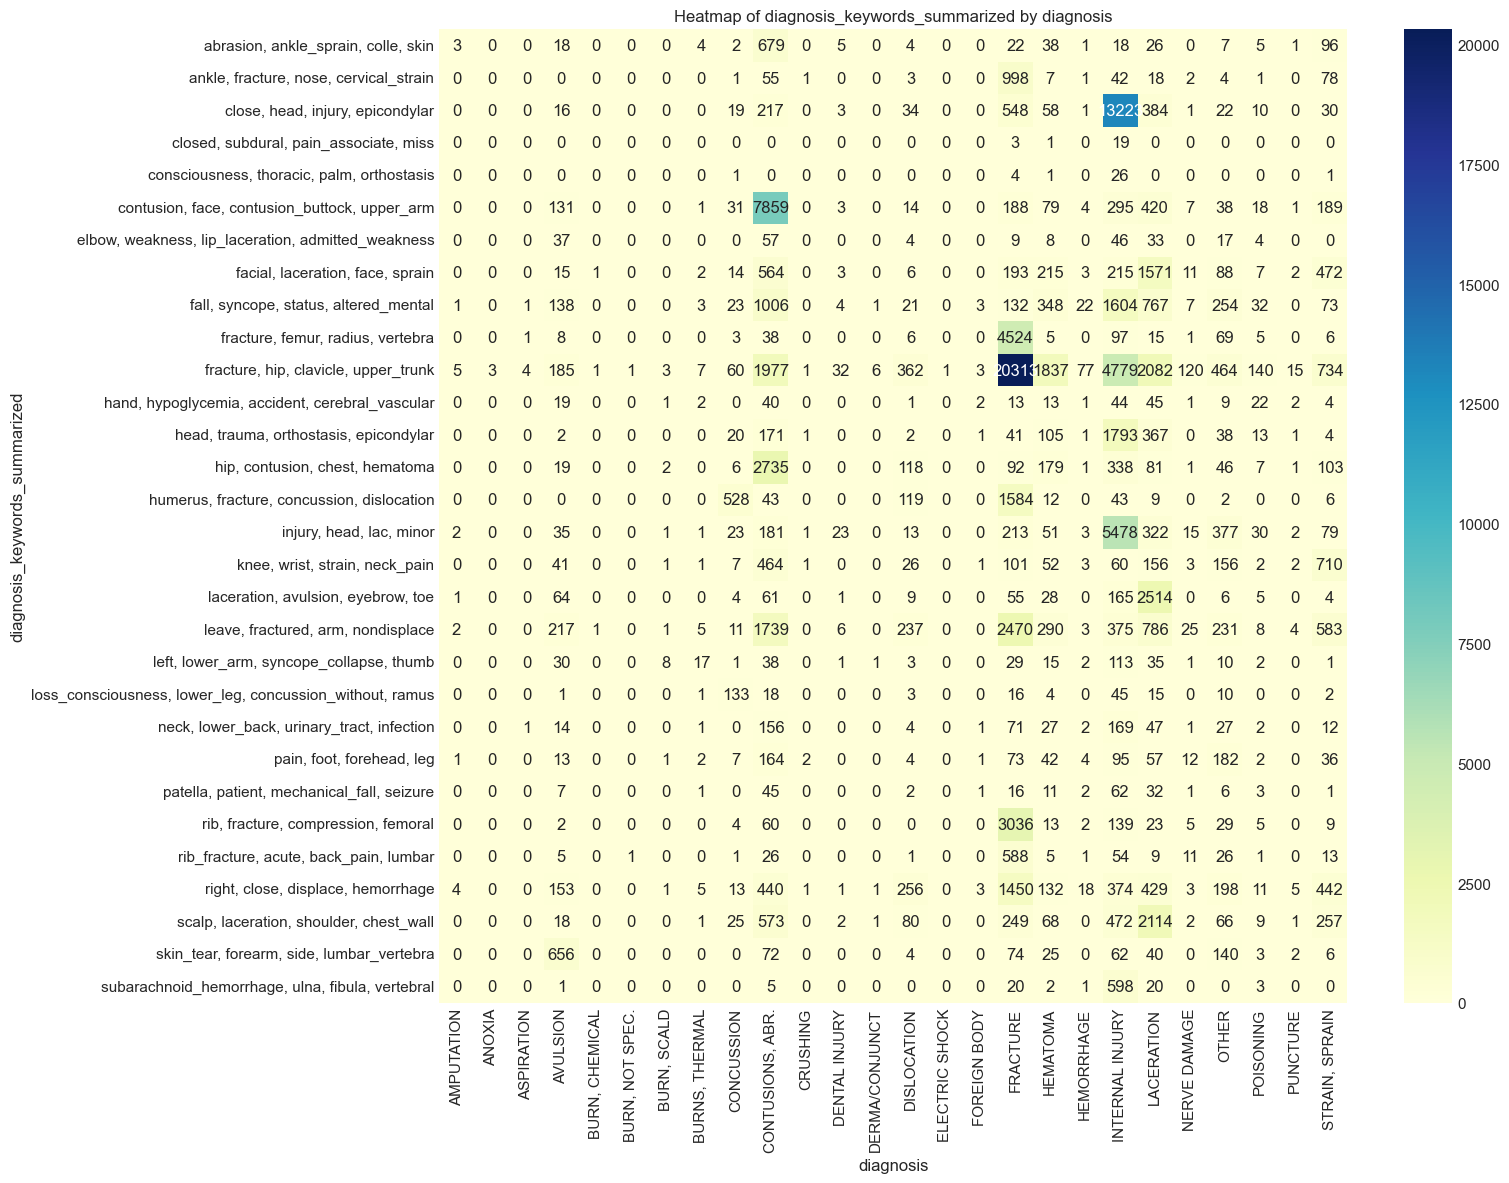

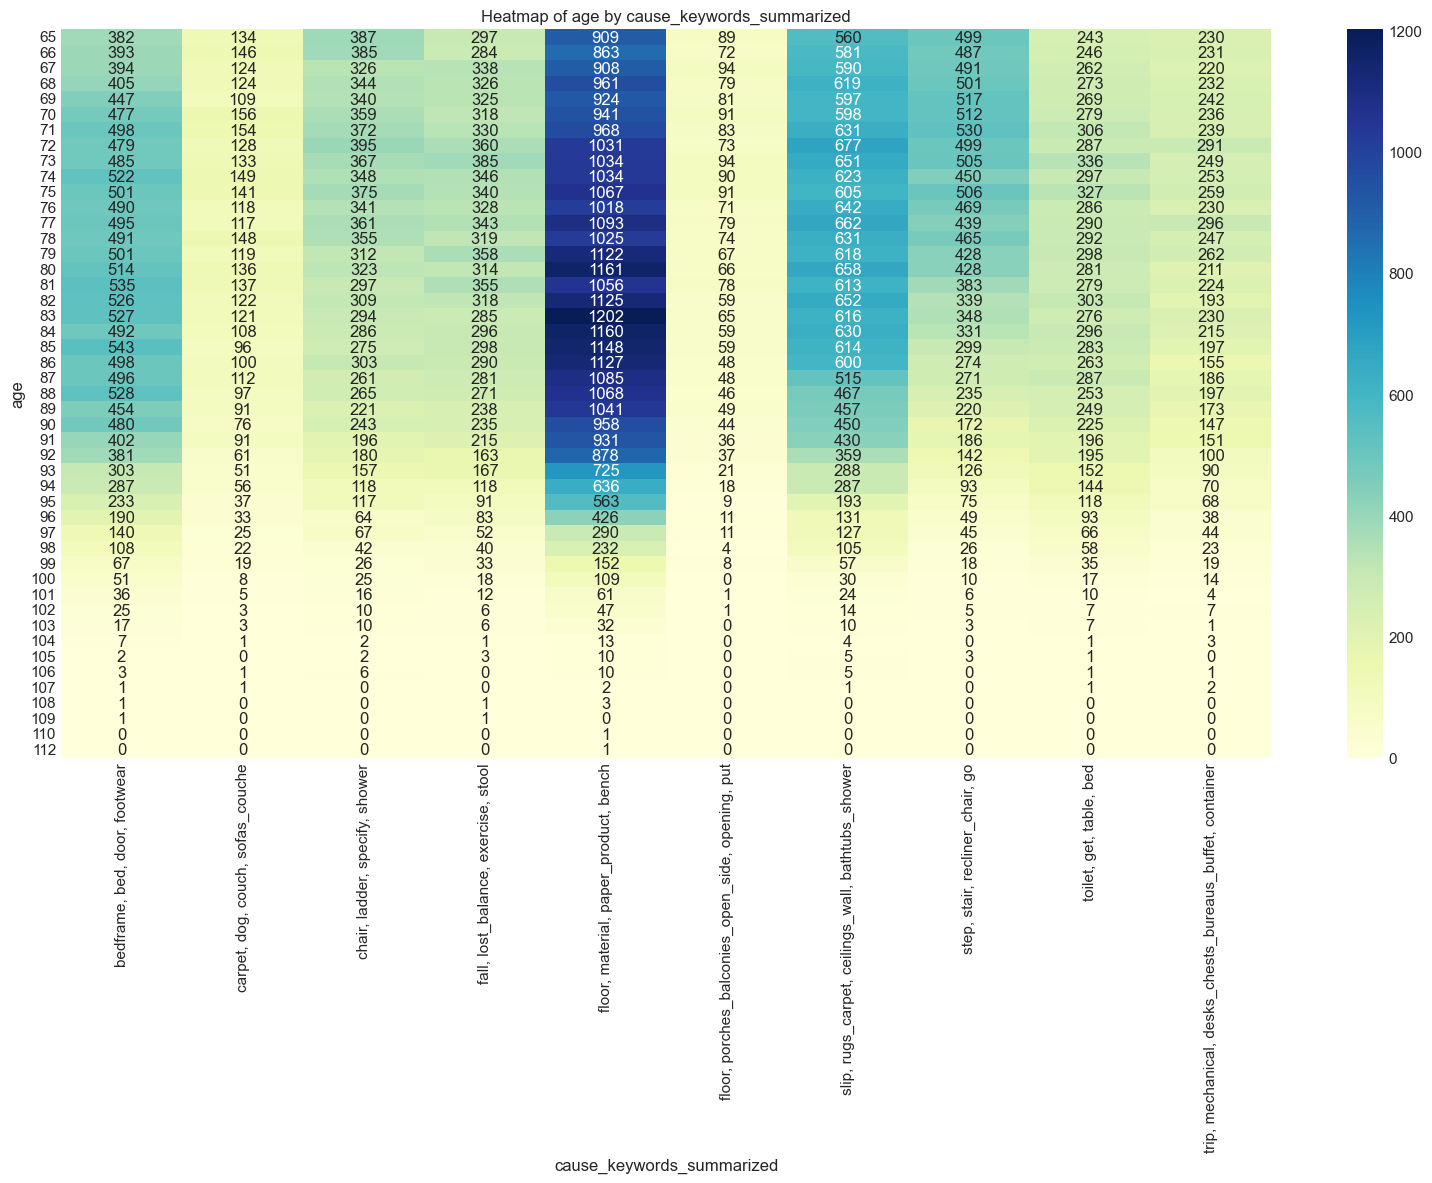

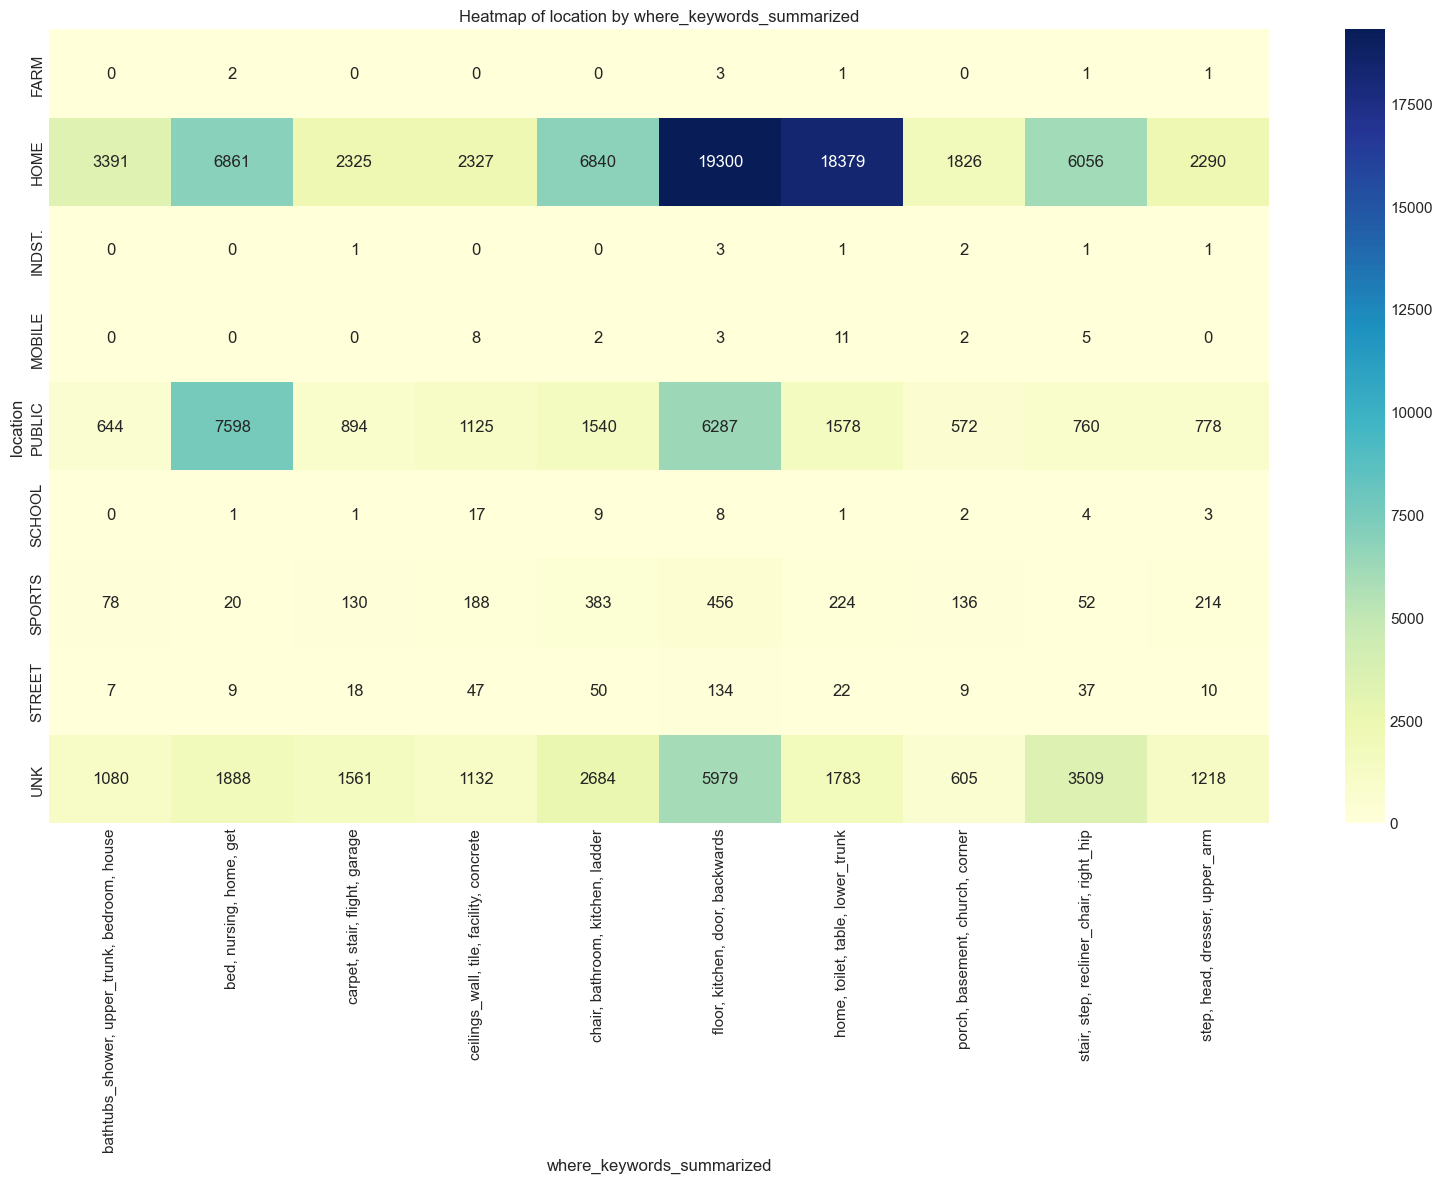

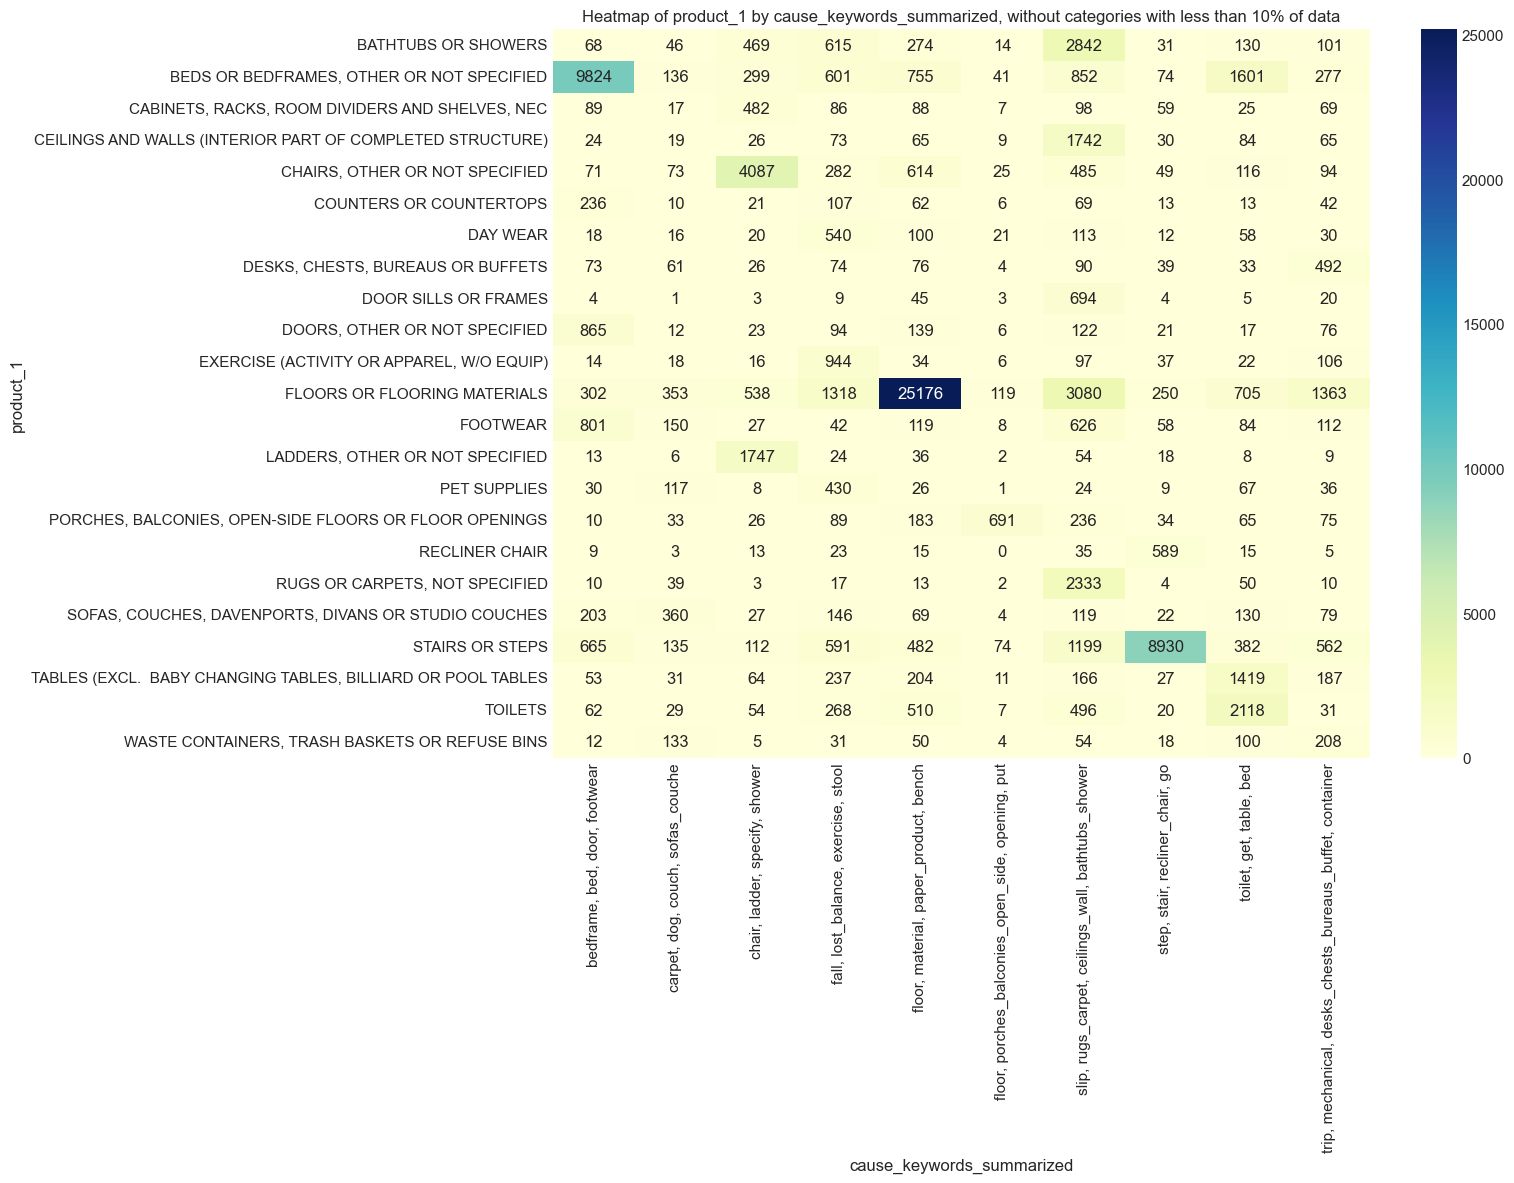

In [43]:
def plot_heatmap(col1, col2, drop_threshold=0):
    cross_tab = pd.crosstab(analysis[col1], analysis[col2])
    
    if drop_threshold:
        threshold = 0.005 * cross_tab.values.sum()

        # Filter rows and columns based on the threshold
        cross_tab = cross_tab.loc[
            cross_tab.sum(axis=1) >= threshold,
            cross_tab.columns[cross_tab.sum(axis=0) >= threshold]
        ]

    # create a heatmap using Seaborn
    plt.figure(figsize=(16, 12))
    sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g')
    
    if drop_threshold:
        plt.title(f"Heatmap of {col1} by {col2}, without categories with less than {int(drop_threshold*100)}% of data")
    else:
        plt.title(f"Heatmap of {col1} by {col2}")
    
    plt.tight_layout()
    plt.show()
    
plot_heatmap(col1="body_part", col2="where_keywords_summarized")
plot_heatmap(col1="diagnosis_keywords_summarized", col2="diagnosis")
plot_heatmap(col1="age", col2="cause_keywords_summarized")
plot_heatmap(col1="location", col2="where_keywords_summarized")
plot_heatmap(col1="product_1", col2="cause_keywords_summarized", drop_threshold=0.1)

Looking especially at the last figure, we can use a visualization like this to get a better idea of how our topics compare with the tabular variables, checking if the relationship between them make sense.

## 3.2 Understanding the topics better

There are many ways to make sense of the topics in order to understand what are categories that they create. I tried using an automated technique to create readable labels for each topic (the one mentioned [here](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)), but it wasn't successful. As a manual alternative, we can explore the most frequent topics and look at the keywords that form them and also some of the most representative narratives of each topic (i.e. the ones with the highest score for each topic). This is a step where an expert in this kind of data would be extremely useful!

In [44]:
def get_most_representative(question, topic, amount=5):
    question_df = analysis[[f"{question}_topic", f"{question}_score", f"{question}_keywords", f"{question}_answer", f"{question}_processed", "narrative_processed"]].copy()
    
    df_sorted = question_df.sort_values(by=[f"{question}_topic", f"{question}_score"], ascending=[True, False])

    # Group by topic and select top 5 narratives for each group
    most_representative_narratives = df_sorted.groupby(f"{question}_topic").head(amount)
    
    return most_representative_narratives[most_representative_narratives[f"{question}_topic"] == topic]

get_most_representative(question="cause", topic=0)

,cause_topic,cause_score,cause_keywords,cause_answer,cause_processed,narrative_processed
57230,0,0.887776,"slip, rugs_carpet, ceilings_wall, bathtubs_sho...",slipped on wet wood surface of a deck,"['slip', 'wet', 'wood', 'surface', 'deck']",patient last night patient slipped on wet w...
71406,0,0.864137,"slip, rugs_carpet, ceilings_wall, bathtubs_sho...",her foot slipped out from under her from havi...,"['foot', 'slip', 'wet', 'shoe']",patientcomplains of head and back injury. she ...
20005,0,0.864136,"slip, rugs_carpet, ceilings_wall, bathtubs_sho...",her foot caught under the wheel of the walker,"['foot', 'catch', 'wheel', 'walker']",patient from the nursing home was walking with...
56302,0,0.864136,"slip, rugs_carpet, ceilings_wall, bathtubs_sho...",her foot caught on the wheel of her walker,"['foot', 'catch', 'wheel', 'walker']",patient was sitting in her chair and when she ...
20510,0,0.864136,"slip, rugs_carpet, ceilings_wall, bathtubs_sho...",her foot got caught on the back wheel of the ...,"['foot', 'got_caught', 'wheel', 'walker']","patient, at extended-care facility, ambulati..."


Having a better understanding of each topic we can create more "abstract" visualization that could even allow us to find other kinds of interesting relationships. For instance, we can visualize how the the count of each topic change over time for each year:

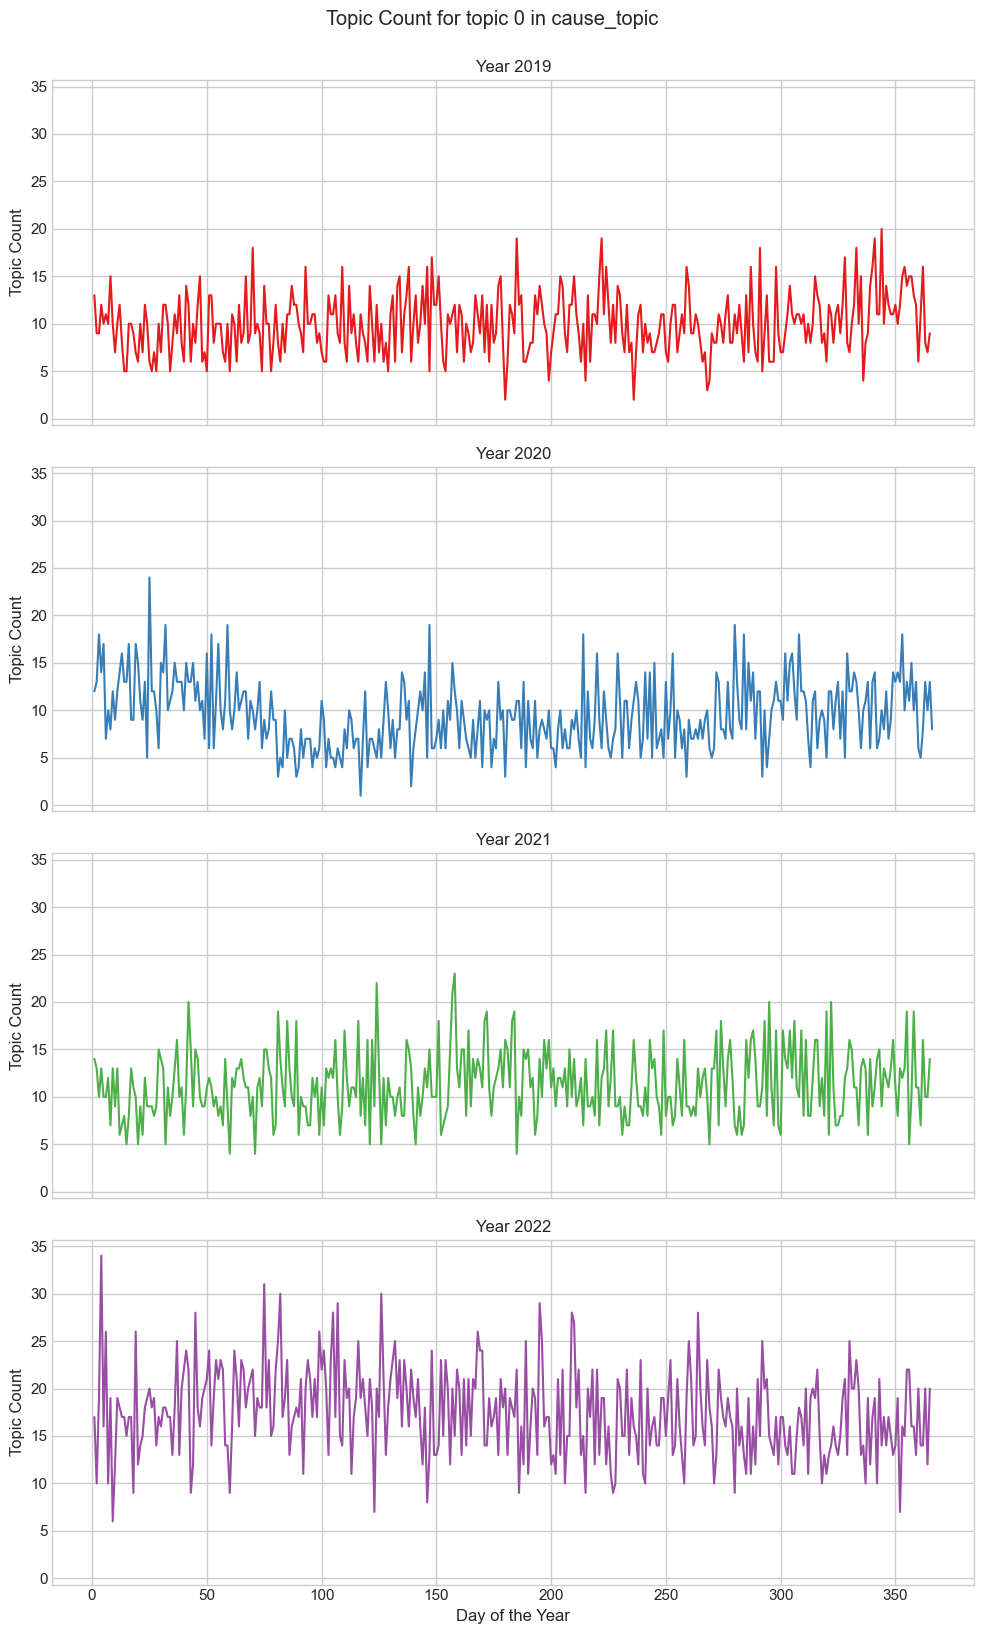

In [45]:
def plot_topic_per_year(topic_col, topic):
    df = analysis.copy()

    df["treatment_date"] = pd.to_datetime(df["treatment_date"])

    # extract year and dayofyear for grouping
    df["year"] = df["treatment_date"].dt.year
    df["dayofyear"] = df["treatment_date"].dt.dayofyear

    # filter data to include only selected topics
    filtered_data = df[df[topic_col] == topic]

    # group by year and dayofyear to count occurrences
    grouped = filtered_data.groupby(["year", "dayofyear"]).size().reset_index(name="count")

    # create subplots for each year with shared x and y axes
    unique_years = grouped["year"].unique()
    num_years = len(unique_years)

    fig, axes = plt.subplots(num_years, 1, figsize=(10, 4 * num_years), sharex=True, sharey=True)

    # define color palette
    palette = sns.color_palette("Set1", num_years)

    for i, year in enumerate(unique_years):
        ax = axes[i]
        year_data = grouped[grouped["year"] == year]
        
        # assign a unique color to the subplot based on the palette
        color = palette[i]
        
        sns.lineplot(data=year_data, x="dayofyear", y="count", ax=ax, color=color)
        ax.set_title(f"Year {year}")
        ax.set_ylabel("Topic Count")
        
    plt.xlabel("Day of the Year")
    plt.tight_layout()
    plt.suptitle(f"Topic Count for topic {topic} in {topic_col}", y=1.02)
    plt.show()
    
plot_topic_per_year(topic_col="cause_topic", topic=0)

Finally, for an even more granular exploration, we can check the topic count for each month:

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


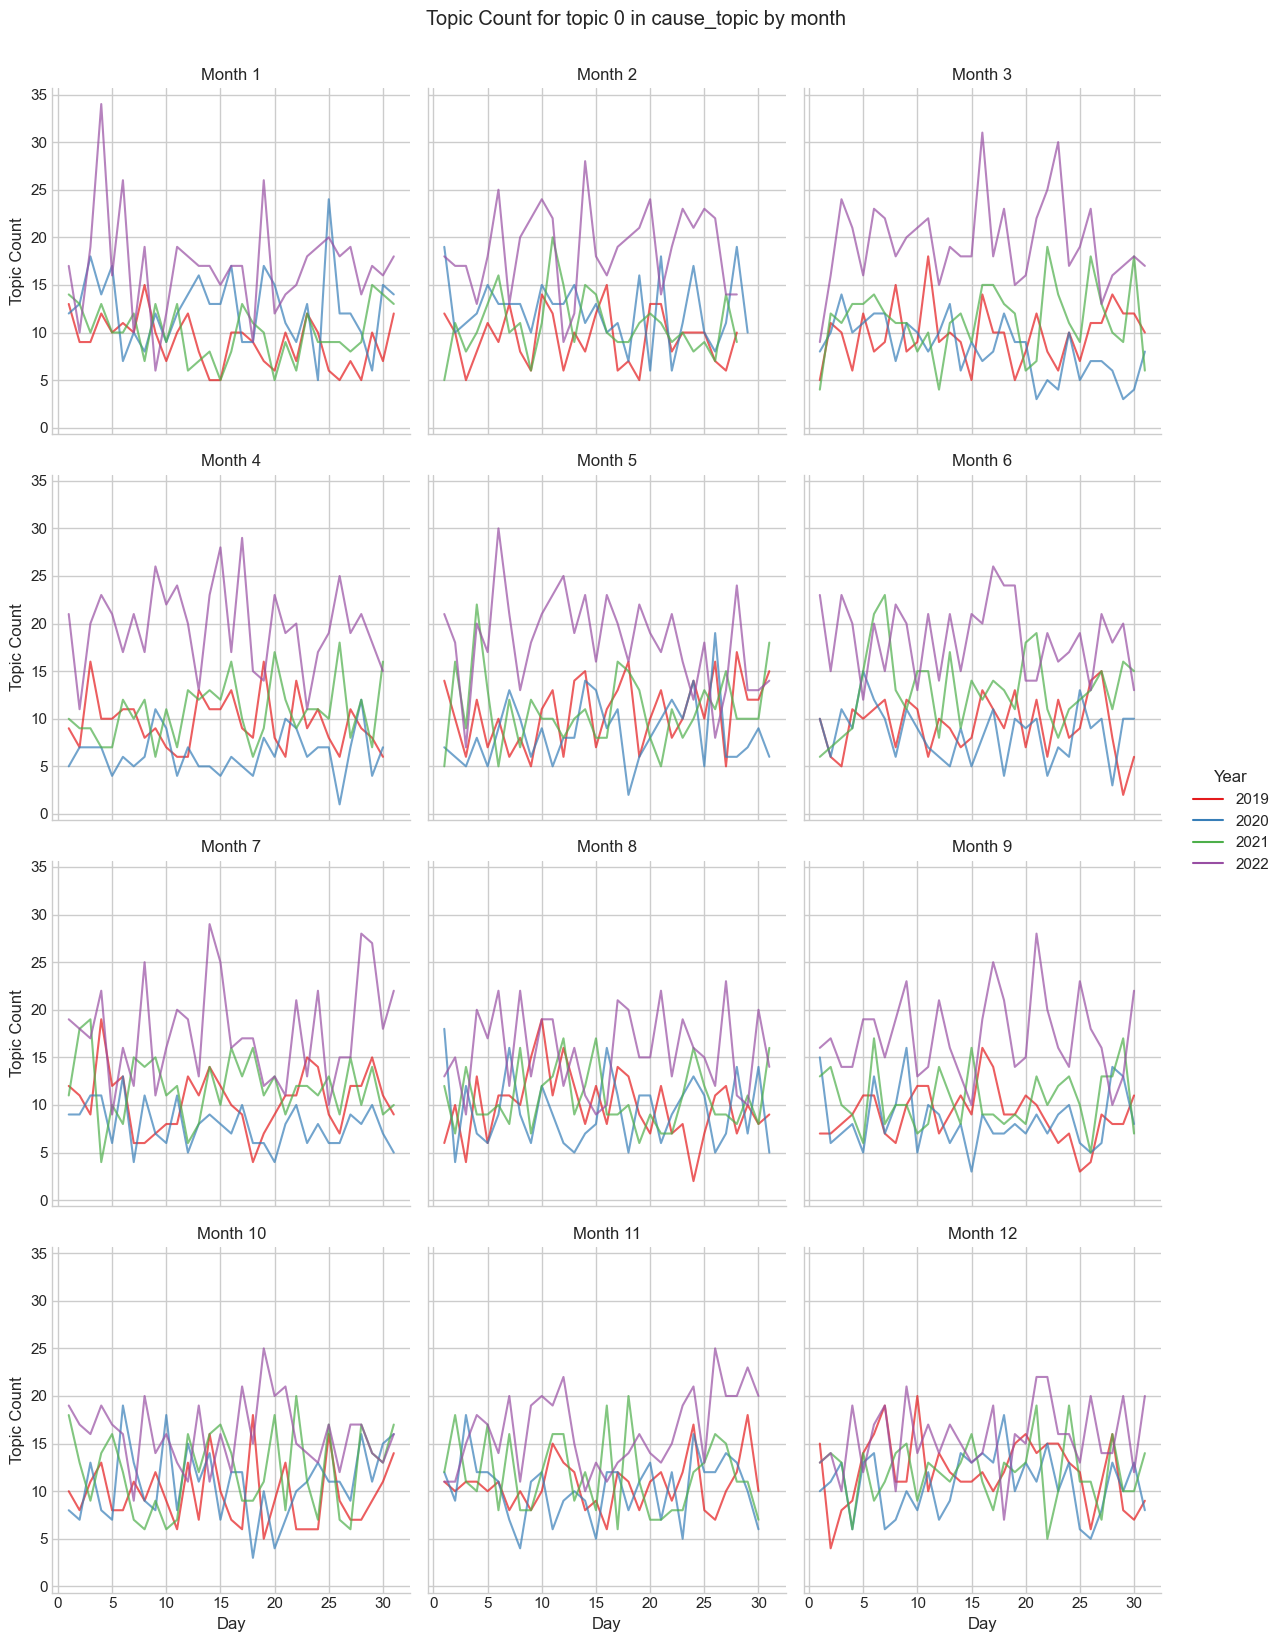

In [46]:
def plot_topic_per_month(topic_col, topic):
    df = analysis.copy()

    df["treatment_date"] = pd.to_datetime(df["treatment_date"])

    # Extract year, month, and day for grouping
    df["year"] = df["treatment_date"].dt.year
    df["month"] = df["treatment_date"].dt.month
    df["day"] = df["treatment_date"].dt.day

    # Filter data to include only selected topics
    filtered_data = df[df[topic_col] == topic]

    # Group by year, month, day, and topic to count occurrences
    grouped = filtered_data.groupby(["year", "month", "day", topic_col]).size().reset_index(name="count")

    # Create a FacetGrid using seaborn for each month
    g = sns.FacetGrid(grouped, col="month", col_wrap=3, height=4, sharey=True)
    g.map_dataframe(
        lambda data, **kwargs: sns.lineplot(data=data, x="day", y="count", hue="year", palette="Set1", alpha=0.7, **kwargs)
    )
    
    g.set_axis_labels("Day", "Topic Count")
    g.add_legend(title="Year")

    g.set_titles("Month {col_name}")
    g.tight_layout()

    plt.suptitle(f"Topic Count for topic {topic} in {topic_col} by month", y=1.025)

    plt.show()
    
plot_topic_per_month(topic_col="cause_topic", topic=0)